# SC1235 Introduction to Medical Image Analysis Using Convolutional Neural Networks

<div id="toc"></div>

## 4. Preparing for Image Segmentation

In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPool2D, Flatten, Dense, UpSampling2D, LocallyConnected2D, SpatialDropout2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
import numpy as np
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print("Tensorflow version = {}".format(tf.__version__))
print("Keras      version = {}".format(tf.keras.__version__))

Tensorflow version = 1.13.1
Keras      version = 2.2.4-tf


### Check if a GPU is indeed available

Sometimes, it is useful to be able to check that tensorflow (which is used internally by keras here) is able to see a real GPU. If tensorflow falls back to the CPU, your code will still work, but be *much* slower.

In [3]:
from tensorflow.python.client import device_lib
# print all devices visible to tensorflow 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1607307884778287393
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4947404390
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13178061811147080209
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


The first thing one needs to prepare is how to access the data:
* separation of training & test data
* random access to parts of the data (e.g. single images out of a large database)
* random permutations (shuffling)

In this notebook, we will just load data that we have prepared.  In practice, one might be interested in
* [pydicom](https://pydicom.github.io) for loading DICOM image data
* [HDF5 and h5py](https://www.h5py.org) for efficient storage of large binary data
* [numpy.random.permutation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html) comes in very handy for shuffling large arrays

> If you are already capable of python programming, here are some more hints how you could improve on the approach of this notebook:
> * Create a generator function that loads one batch of size `batch_size` and returns it.
> * Track which images you have already drawn, so that you can start over after one epoch (one epoch is one run through all images) with a fresh permutation.
> * Call the `fit_generator()` function instead of `fit()`.  Read the Keras documentation for this at [keras.io](http://keras.io).
>
> If you still have time and motivation, implement the same using a HDF5 file storage rather than plain disk storage.

### Loading the Data

We have prepared a set of abdominal CT slices, strongly downsampled, completely anonymized, together with segmentation labels which we will inspect shortly.  The following cell just downloads the data to the machine this notebook runs on.

In [4]:
!test -e tmp_slices.npz || curl -L "https://drive.google.com/uc?export=download&id=1R2-H0dhhrj6XNK7Q-MazIWGeFDOf6Zya" --output tmp_slices.npz

'test' is not recognized as an internal or external command,
operable program or batch file.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100   388    0   388    0     0    192      0 --:--:--  0:00:02 --:--:--   192

  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100 11.0M    0 11.0M    0     0  3405k      0 --:--:--  0:00:03 --:--:-- 16.8M
100 16.5M    0 16.5M    0     0  4784k      0 --:--:--  0:00:03 --:--:-- 18.9M


Split into separate training and test sets.

* Training converges with about 200 slices.
* The initial results when training with 700 slices are terrible. (Exercise: Why?)

In [5]:
TRAINING_SLICE_COUNT = 300

In [6]:
loaded = np.load('tmp_slices.npz')

x_train = loaded['x_train'][:TRAINING_SLICE_COUNT]
y_train = loaded['y_train'][:TRAINING_SLICE_COUNT]

x_test = loaded['x_train'][TRAINING_SLICE_COUNT:]
y_test = loaded['y_train'][TRAINING_SLICE_COUNT:]

assert len(x_train) == len(y_train)

### Inspecting the Demo Data
The PNGs used for this hands-on contain abdominal CT scans showing the liver, resampled to 4mm voxel size and after applying a liver HU window (centered at 20 HU, width 450 HU).  The corresponding masks contain values 0 (background), 1 (liver), 2..3 (different classes of lesions):

In [7]:
np.unique(y_test)

array([0., 1., 2., 3.], dtype=float32)

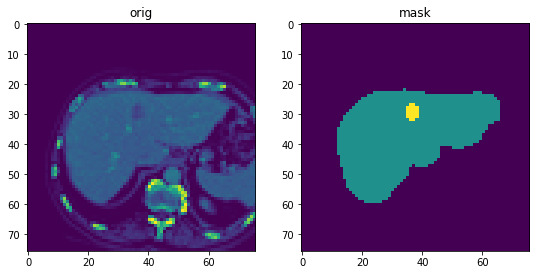

In [8]:
example_test_slice = 1800

f, ax = plt.subplots(1, 2, figsize = (9, 5))
imgplot = ax[0].imshow(x_test[example_test_slice])
ax[0].set_title('orig')
imgplot = ax[1].imshow(y_test[example_test_slice])
ax[1].set_title('mask')
plt.show()

For now, we will start with a binary segmentation problem (0: background, 1: liver), so we will remove the lesion labels / turn them into liver (value 1).

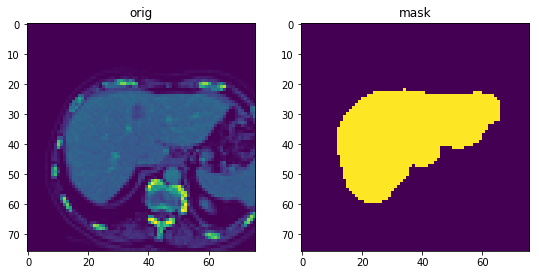

In [9]:
# remove the lesion labels (values 2..3)
y_train_binary = y_train.clip(0, 1)
y_test_binary = y_test.clip(0, 1)

f, ax = plt.subplots(1, 2, figsize = (9, 5))
imgplot = ax[0].imshow(x_test[example_test_slice])
ax[0].set_title('orig')
imgplot = ax[1].imshow(y_test_binary[example_test_slice])
ax[1].set_title('mask')
plt.show()

# 5. Segmentation: Auto Encoder (AE)-Style
* We define short functions that return a model.
* The first is a simple architecture that collapses and expands an image into the desired mask, similar to an Auto Encoder (AE).
* The second is the famous U-Net.

Further reading: Variational AE

In [30]:
def getModel(_filters=32, filters_add=0, _kernel_size=(3,3), _padding='same', _activation='relu', _kernel_regularizer=None, _final_layer_nonlinearity='sigmoid'):
    model = Sequential()
    # We are indifferent about the xy size, but accept only one channel (gray value images). This has the consequence that debugging sizes gets harder.
    model.add(InputLayer(input_shape=(None,None,1))) 
    
    model.add(BatchNormalization())
    model.add(Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, name='firstConvolutionalLayer'))
    model.add(SpatialDropout2D(0.3))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer))
    model.add(SpatialDropout2D(0.3))
    model.add(MaxPool2D())

    model.add(BatchNormalization())
    model.add(Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer))
    model.add(SpatialDropout2D(0.3))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer))
    model.add(SpatialDropout2D(0.3))
    model.add(MaxPool2D())

    model.add(BatchNormalization())
    model.add(Conv2D(filters=_filters+2*filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=_filters+2*filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer))
    model.add(UpSampling2D())

    model.add(BatchNormalization())
    model.add(Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer))
    model.add(UpSampling2D())

    model.add(BatchNormalization())
    model.add(Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer))

    model.add(BatchNormalization())
    model.add(Conv2D(1, kernel_size=(1,1), activation=_final_layer_nonlinearity))
    return model

In [31]:
def getDropoutBayesModel(_filters=32, filters_add=0, _kernel_size=(3,3), _padding='same', _activation='relu', _kernel_regularizer=None, _final_layer_nonlinearity='sigmoid'):
    model = Sequential()
    # We are indifferent about the xy size, but accept only one channel (gray value images). This has the consequence that debugging sizes gets harder.
    input_layer = Input(shape=(None,None,1))
    
    x = BatchNormalization()(input_layer)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, name='firstConvolutionalLayer')(x)
    x = SpatialDropout2D(0.3)(x, training=True)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = SpatialDropout2D(0.3)(x, training=True)
    x = MaxPool2D()(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = SpatialDropout2D(0.3)(x, training=True)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = SpatialDropout2D(0.3)(x, training=True)
    x = MaxPool2D()(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+2*filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+2*filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = UpSampling2D()(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = UpSampling2D()(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)

    x = BatchNormalization()(x)
    output_layer = Conv2D(1, kernel_size=(1,1), activation=_final_layer_nonlinearity)(x)
    
    model = Model(input_layer, output_layer)
    return model

In [32]:
from tensorflow_probability.python.layers import Convolution2DFlipout

def getProbBayesModel(_filters=32, filters_add=0, _kernel_size=(3,3), _padding='same', _activation='relu', _kernel_regularizer=None, _final_layer_nonlinearity='sigmoid'):
    model = Sequential()
    # We are indifferent about the xy size, but accept only one channel (gray value images). This has the consequence that debugging sizes gets harder.
    input_layer = Input(shape=(None,None,1))
    
    x = BatchNormalization()(input_layer)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, name='firstConvolutionalLayer')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = MaxPool2D()(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = MaxPool2D()(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+2*filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+2*filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = UpSampling2D()(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = UpSampling2D()(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)

    x = BatchNormalization()(x)
    x = Convolution2DFlipout(filters=_filters, kernel_size=(1,1), activation=_activation)(x)
    output_layer = Convolution2DFlipout(1, kernel_size=(1,1), activation=_final_layer_nonlinearity)(x)
    
    model = Model(input_layer, output_layer)
    return model


In [62]:
from tensorflow_probability.python.layers import Convolution2DFlipout
from tensorflow.keras.layers import Conv2DTranspose

def getProbBayesModernModel(_filters=32, filters_add=0, _kernel_size=(3,3), _padding='same', _activation='relu', _kernel_regularizer=None, _final_layer_nonlinearity='sigmoid'):
    model = Sequential()
    # We are indifferent about the xy size, but accept only one channel (gray value images). This has the consequence that debugging sizes gets harder.
    input_layer = Input(shape=(None, None,1))
    
    x = BatchNormalization()(input_layer)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, name='firstConvolutionalLayerTranspose')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, strides=(2,2), padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, strides=(2,2), padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+2*filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters=_filters+2*filters_add, kernel_size=_kernel_size, strides=2, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters+filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(filters=_filters+filters_add, kernel_size=_kernel_size, strides=2, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)

    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)(x)

    x = BatchNormalization()(x)
#    x = Convolution2DFlipout(filters=_filters, kernel_size=(1,1), activation=_activation)(x)
    output_layer = Convolution2DFlipout(1, kernel_size=(1,1), activation=_final_layer_nonlinearity)(x)
    
    model = Model(input_layer, output_layer)
    return model


## Convolution Mode 'valid' vs. 'same' / Automatic Padding

In case you use convolutions with `'valid'` padding, the input size needs to be padded before submitting so that still an output corresponding to the full slice (or the patch size, respectively) is generated. The number of pixels to pad depends on the network architecture. There is an excellent technical report detailing the arithmetics to calculate the receptive field and required padding from a network definition at https://arxiv.org/pdf/1603.07285.pdf. Another description is at https://medium.com/@Synced/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-42f33d4378e0.

We will explore the difference later in the context of _overlapping tiles segmentation_.
The function is somewhat hard-coded for the network architecture above: it pads the input with a fixed amount of voxels in case the model gives an output that is differently sized from the inmput.

In [74]:
def pad_image_for_model(model, input_image):
    '''Determine the necessary amount of padding
    (difference between input and output size of the model)
    and apply it to an ndarry with one or more images.'''
    
    padding = 0
    if 'firstConvolutionalLayer' in [layer.name for layer in model_ProbBayesModern.layers]:
        if model.get_layer('firstConvolutionalLayer').padding == 'valid':
            padding = 20 # WARNING: Hard-coded for above architecture!

            # determine in which dimension to apply this padding
            ndim_padding = []
            if np.ndim(input_image) > 2:
                # do not pad along batch dimension (if present)
                ndim_padding.append((0, 0))
            ndim_padding.append((padding, padding)) # pad above/below image (y dimension)
            ndim_padding.append((padding, padding)) # pad left/right of image (x dimension)
            if np.ndim(input_image) > 3:
                # do not pad along channel dimension (if present)
                ndim_padding.append((0, 0))

            input_image = np.lib.pad(input_image, ndim_padding,
                                     #'constant', constant_values = 0)
                                     'reflect')

    return input_image, padding

For our small data, it is possible to train a classifier that takes full slices. However, when dealing with input of arbitrary size, this will no longer work. Images have to be partitioned, and the individual results need to be stitched into the final output. This only works when padding the input with blank or other voxels to achieve the desired output size.

### Experiment 1: 'valid' Convolutions

Get a model with padding of 'valid', i.e. the size will shrink and a proper amount of voxels need to be added prior to processing.

In [35]:
modelValid = getModel(_padding = 'valid')

modelValid.compile(loss='binary_crossentropy', optimizer='adam')
print("Model parameters: {0:,}".format(modelValid.count_params()))

Model parameters: 84,869


### Experiment 2: 'same' Convolutions

Get a model with `same` padding, i.e. the input is padded with zeros before each convolution such that an output size equal to the input is achieved. 

In [28]:
modelSame = getModel()

modelSame.compile(loss='binary_crossentropy', optimizer='adam')
print("Model parameters: {0:,}".format(modelSame.count_params()))

Model parameters: 84,869


### Experiments: Uncertainty by Dropout and Prob. Layers

In [37]:
modelBayesValid = getDropoutBayesModel(_padding = 'valid')

modelBayesValid.compile(loss='binary_crossentropy', optimizer='adam')
print("Model parameters: {0:,}".format(modelBayesValid.count_params()))

Model parameters: 84,869


In [41]:
model_ProbBayes = getProbBayesModel(_padding = 'valid')
model_ProbBayes.compile(loss='binary_crossentropy', optimizer='adam')
print("Model parameters: {0:,}".format(model_ProbBayes.count_params()))

Model parameters: 86,981


In [75]:
model_ProbBayesModern = getProbBayesModernModel(_padding = 'same')
model_ProbBayesModern.compile(loss='binary_crossentropy', optimizer='adam')
print("Model parameters: {0:,}".format(model_ProbBayesModern.count_params()))

Model parameters: 84,901


## Executing code during training

This is a small interludium section that isn't directly related to the experiments around the overlapping tile concept.

In Keras (and also other frameworks), code can be executed with every iteration/batch/... Keras makes this particularly easy by offering "callbacks" where you can override one or more functions to execute your code. We will use this to generate images of the learning success after each epoch.

In [26]:
from tensorflow.keras.callbacks import Callback

class VisualHistory(Callback):
    def on_train_begin(self, logs={}):
        # also show initial prediction
        plot_prediction(self.model, example_test_slice)
    
    def on_epoch_end(self, batch, logs={}):
        # show prediction after every training epoch
        plot_prediction(self.model, example_test_slice)
        
vh_callback = VisualHistory()

Once a model is trained, you'll want to evaluate it. Predicting using a given model and then plotting one slice is implemented in this function. 

In [27]:
def do_prediction(model, input_image, verbose = False):
    # first do padding of full slice
    input_image, padding = pad_image_for_model(model, input_image)
    
    # add batch and channel dimensions (network expects 4D arrays)
    input_array = input_image[np.newaxis,:,:,np.newaxis]
    if verbose:
        print("input shape:", input_array.shape)

    y_predicted = model.predict(input_array)
    if verbose:
        print("output shape:", y_predicted.shape)

    return input_image, input_array, y_predicted, padding

def plot_prediction(model, pred_slice_index):
    # get single slice
    input_image    = x_test[pred_slice_index]
    # could use y_train_binary here for the first half of the notebook, but in the end we want to see the lesion
    reference_mask = y_test[pred_slice_index]

    input_image, input_array, y_predicted, padding = do_prediction(model, input_image)
    
    padded_extent = np.array([0, input_array.shape[2], input_array.shape[1], 0]) - 0.5 - padding

    # display prediction for inspection
    f, ax = plt.subplots(1, 5 if padding else 4, figsize = (11 if padding else 8, 3), sharey = True)
    ax[0].imshow(x_test[pred_slice_index])
    ax[0].set_title('orig')
    if padding:
        ax[1].imshow(input_array[0,:,:,0], extent = padded_extent)
        ax[1].set_title('padded input')
    ax[-2].imshow(y_predicted[0,:,:,0])
    ax[-2].set_title('predicted mask')
    ax[-3].imshow(reference_mask.clip(0,1))
    ax[-3].set_title('reference mask')
    ax[-1].imshow(reference_mask.clip(0,1) - y_predicted[0,:,:,0])
    ax[-1].set_title('(ref - predicted)')
    ax[0].set_ylim(*padded_extent[2:])
    plt.show()

## Training
* As the arrays we created before are 3-dimensional (no channel for grey images), we have to add one dimension to make it compatible with the ConvNet.
* About 100 epochs lead to a pretty well-performing net. On an average CPU, one iteration takes about 10-15 sec. On GPU, this is much faster (increase the batch size also, to avoid unneccessary GPU memory transfers)
* With Batch Normalisation and PReLU, the number of parameters gets much larger, and training takes much longer. 
    * Does the result warrant the wait?
    * Explain!
* Callbacks enable better logging. 
    * We can add the TensorBoard logging mechanism. 
    * TensorBoard needs to be started externally, pointing to the log directory, which defaults to `./logs`.

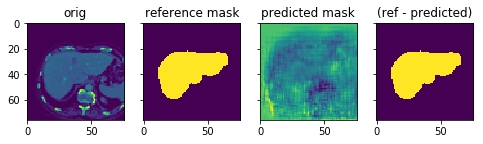

Epoch 1/5
260/300 [=========================>....] - ETA: 0s - loss: 13.8409

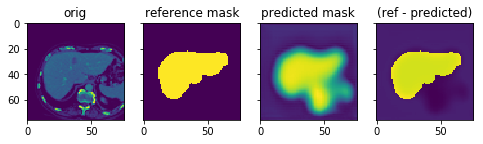

300/300 [==============================] - 3s 9ms/sample - loss: 13.5645
Epoch 2/5
260/300 [=========================>....] - ETA: 0s - loss: 9.8019

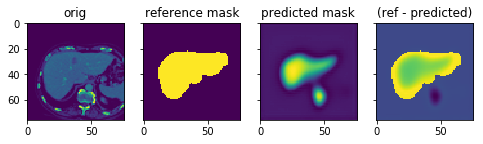

300/300 [==============================] - 1s 3ms/sample - loss: 9.7149
Epoch 3/5
260/300 [=========================>....] - ETA: 0s - loss: 7.8980

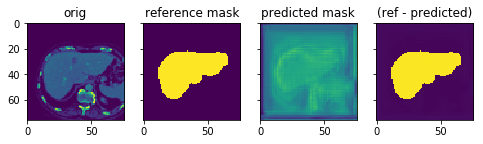

300/300 [==============================] - 1s 3ms/sample - loss: 7.8660
Epoch 4/5
260/300 [=========================>....] - ETA: 0s - loss: 6.9541

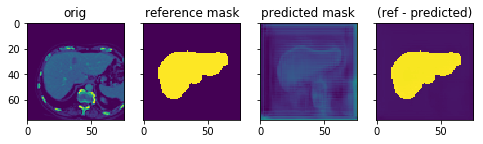

300/300 [==============================] - 1s 3ms/sample - loss: 6.8839
Epoch 5/5
260/300 [=========================>....] - ETA: 0s - loss: 5.5066

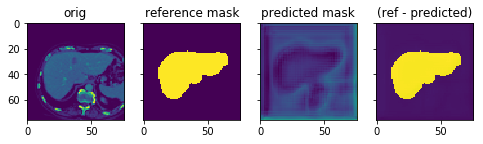

300/300 [==============================] - 1s 3ms/sample - loss: 5.5078


In [33]:
# This is for _padding = 'same'
historySame = modelSame.fit(x_train[...,np.newaxis],
                            y_train_binary[...,np.newaxis],
                            batch_size=20, epochs=5, callbacks=[vh_callback])

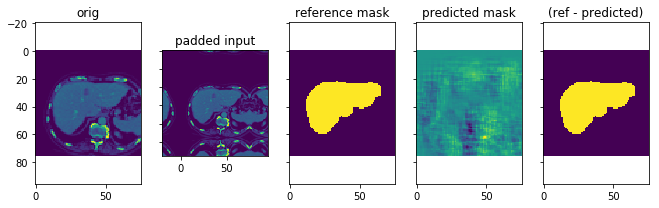

Epoch 1/50
280/300 [===========================>..] - ETA: 0s - loss: 14.1579

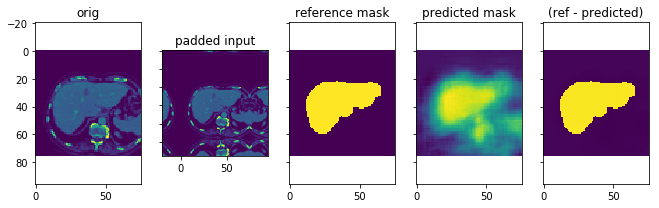

300/300 [==============================] - 4s 13ms/sample - loss: 14.0134
Epoch 2/50
280/300 [===========================>..] - ETA: 0s - loss: 10.3908

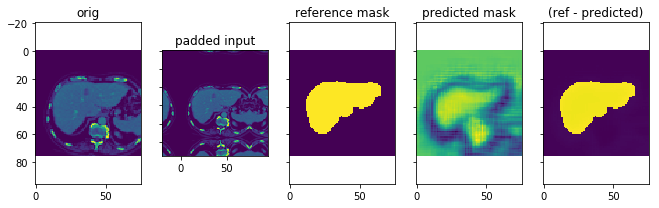

300/300 [==============================] - 1s 5ms/sample - loss: 10.4061
Epoch 3/50
280/300 [===========================>..] - ETA: 0s - loss: 8.3327

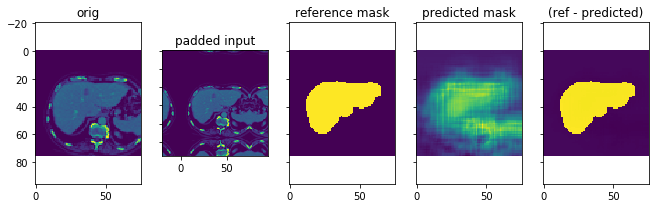

300/300 [==============================] - 1s 5ms/sample - loss: 8.1480
Epoch 4/50
280/300 [===========================>..] - ETA: 0s - loss: 6.9055

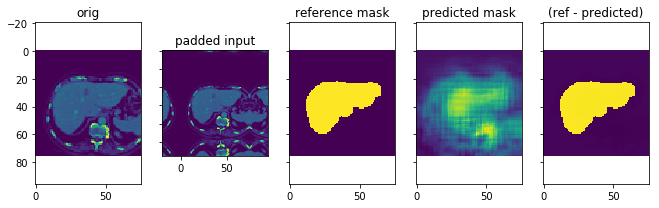

300/300 [==============================] - 1s 4ms/sample - loss: 6.8055
Epoch 5/50
280/300 [===========================>..] - ETA: 0s - loss: 5.7610

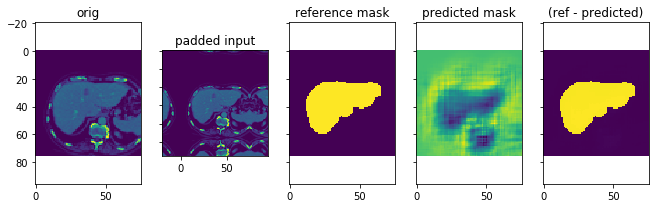

300/300 [==============================] - 1s 4ms/sample - loss: 5.7321
Epoch 6/50
280/300 [===========================>..] - ETA: 0s - loss: 5.1618

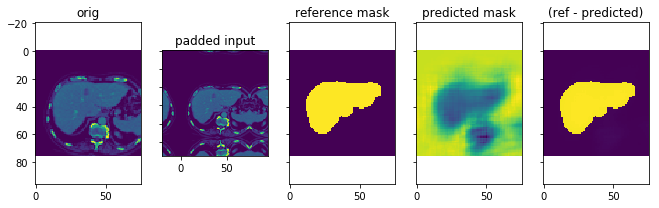

300/300 [==============================] - 1s 5ms/sample - loss: 5.0603
Epoch 7/50
280/300 [===========================>..] - ETA: 0s - loss: 4.3029

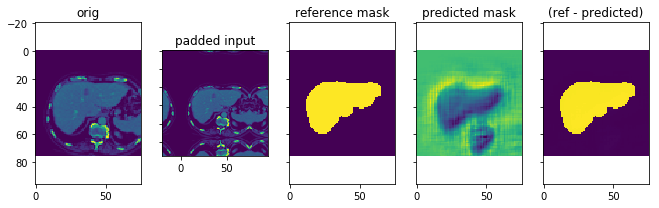

300/300 [==============================] - 2s 6ms/sample - loss: 4.4719
Epoch 8/50
280/300 [===========================>..] - ETA: 0s - loss: 3.9358

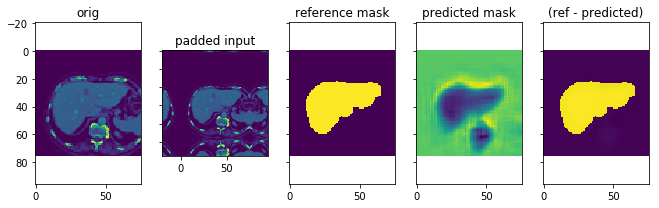

300/300 [==============================] - 1s 5ms/sample - loss: 3.9162
Epoch 9/50
280/300 [===========================>..] - ETA: 0s - loss: 3.5259

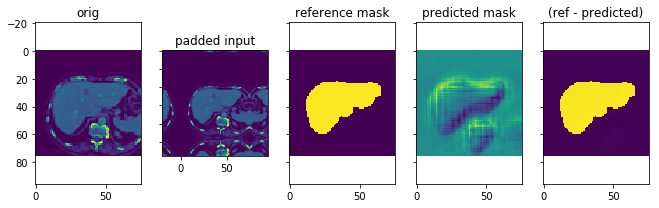

300/300 [==============================] - 1s 4ms/sample - loss: 3.5449
Epoch 10/50
280/300 [===========================>..] - ETA: 0s - loss: 3.1675

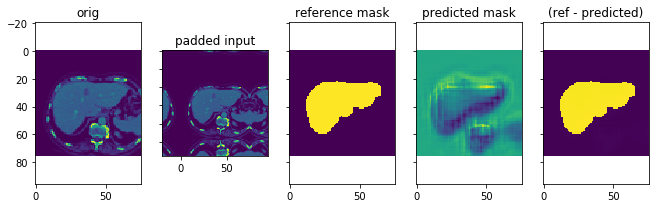

300/300 [==============================] - 1s 4ms/sample - loss: 3.1494
Epoch 11/50
280/300 [===========================>..] - ETA: 0s - loss: 2.8416

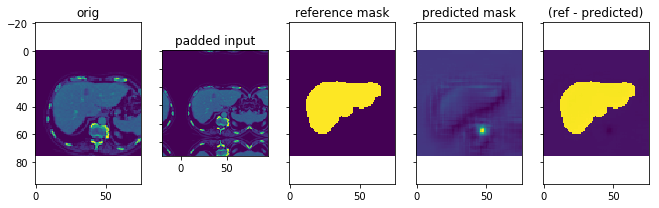

300/300 [==============================] - 1s 4ms/sample - loss: 2.8450
Epoch 12/50
280/300 [===========================>..] - ETA: 0s - loss: 2.6598

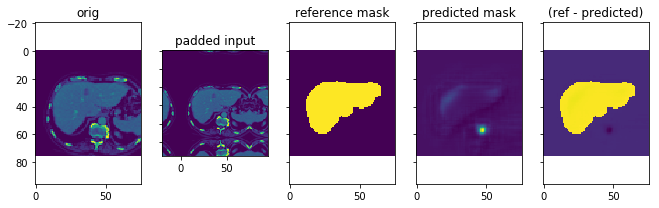

300/300 [==============================] - 2s 5ms/sample - loss: 2.6943
Epoch 13/50
280/300 [===========================>..] - ETA: 0s - loss: 2.4668

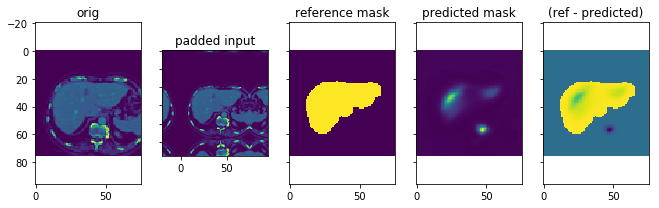

300/300 [==============================] - 2s 5ms/sample - loss: 2.4439
Epoch 14/50
280/300 [===========================>..] - ETA: 0s - loss: 2.3043

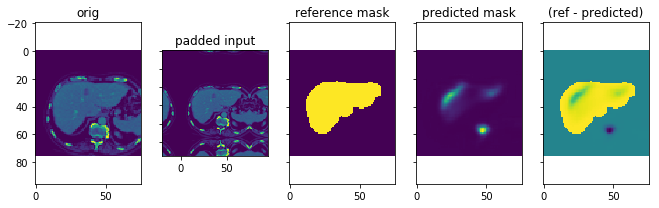

300/300 [==============================] - 2s 6ms/sample - loss: 2.2809
Epoch 15/50
280/300 [===========================>..] - ETA: 0s - loss: 2.2037

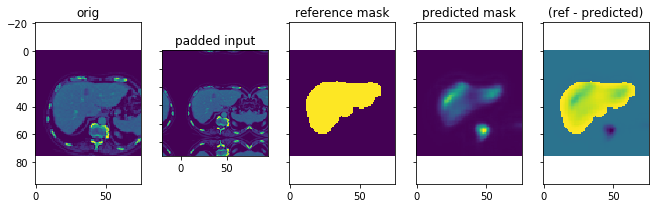

300/300 [==============================] - 1s 5ms/sample - loss: 2.1823
Epoch 16/50
280/300 [===========================>..] - ETA: 0s - loss: 2.0683

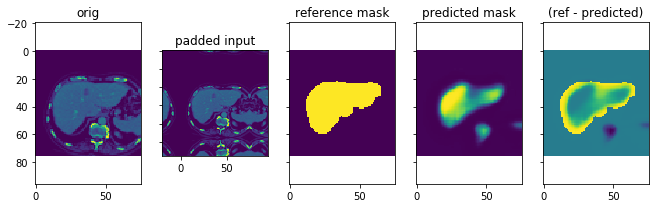

300/300 [==============================] - 1s 4ms/sample - loss: 2.0729
Epoch 17/50
280/300 [===========================>..] - ETA: 0s - loss: 1.8343

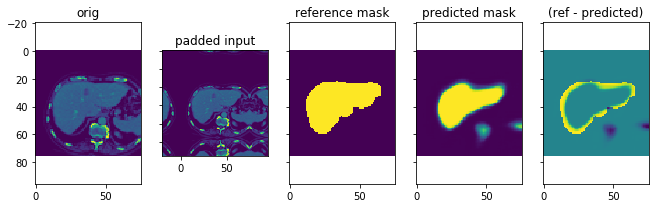

300/300 [==============================] - 2s 5ms/sample - loss: 1.8249
Epoch 18/50
280/300 [===========================>..] - ETA: 0s - loss: 1.8758

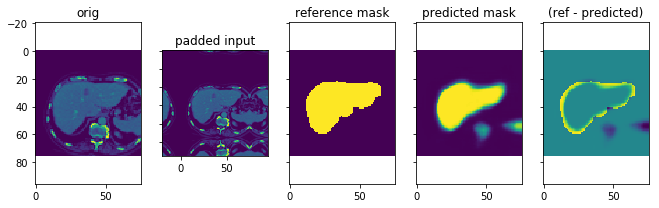

300/300 [==============================] - 1s 4ms/sample - loss: 1.8761
Epoch 19/50
280/300 [===========================>..] - ETA: 0s - loss: 1.8462

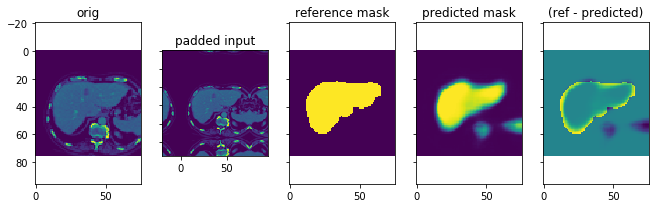

300/300 [==============================] - 2s 6ms/sample - loss: 1.8214
Epoch 20/50
280/300 [===========================>..] - ETA: 0s - loss: 1.7648

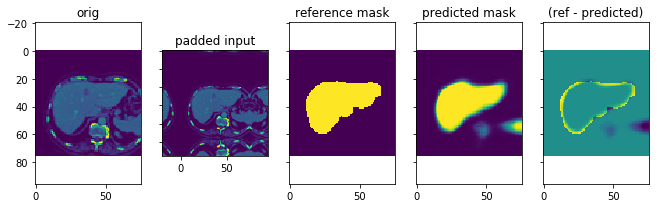

300/300 [==============================] - 2s 6ms/sample - loss: 1.7261
Epoch 21/50
280/300 [===========================>..] - ETA: 0s - loss: 1.6066

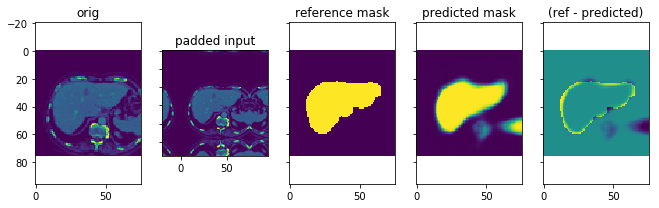

300/300 [==============================] - 1s 5ms/sample - loss: 1.5814
Epoch 22/50
280/300 [===========================>..] - ETA: 0s - loss: 1.6531

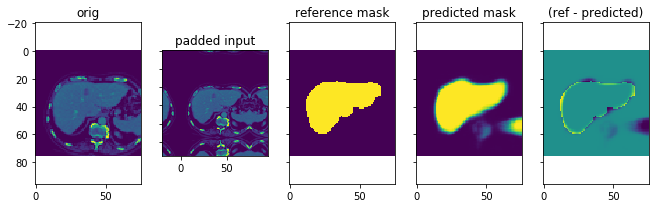

300/300 [==============================] - 1s 4ms/sample - loss: 1.6357
Epoch 23/50
280/300 [===========================>..] - ETA: 0s - loss: 1.5845

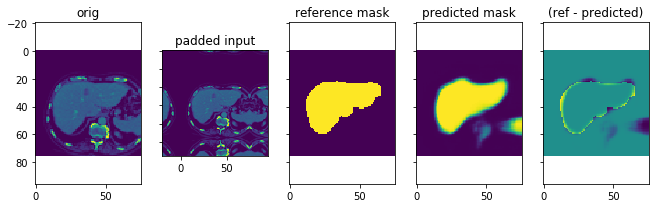

300/300 [==============================] - 1s 4ms/sample - loss: 1.5828
Epoch 24/50
280/300 [===========================>..] - ETA: 0s - loss: 1.5586

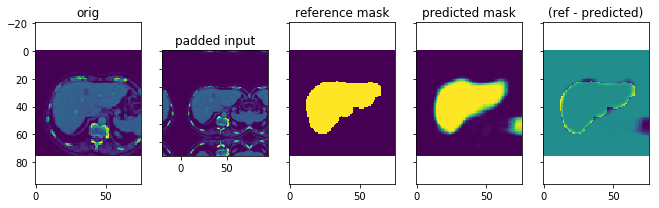

300/300 [==============================] - 1s 4ms/sample - loss: 1.5347
Epoch 25/50
280/300 [===========================>..] - ETA: 0s - loss: 1.4657

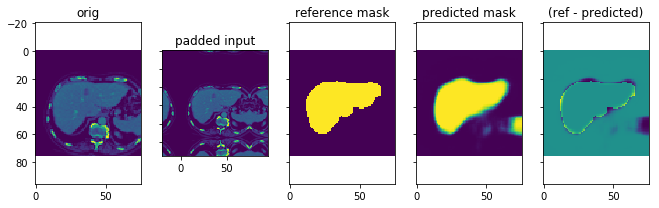

300/300 [==============================] - 1s 4ms/sample - loss: 1.4461
Epoch 26/50
280/300 [===========================>..] - ETA: 0s - loss: 1.3641

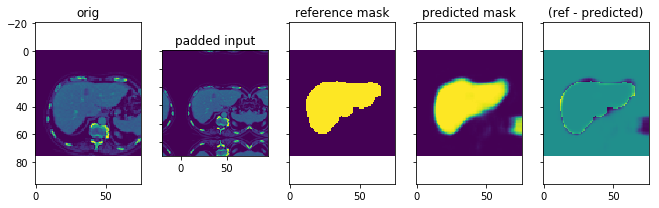

300/300 [==============================] - 1s 4ms/sample - loss: 1.3719
Epoch 27/50
280/300 [===========================>..] - ETA: 0s - loss: 1.3781

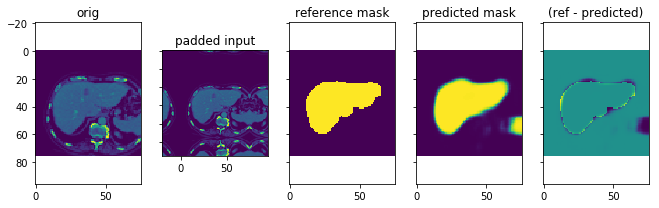

300/300 [==============================] - 1s 4ms/sample - loss: 1.3646
Epoch 28/50
280/300 [===========================>..] - ETA: 0s - loss: 1.3820

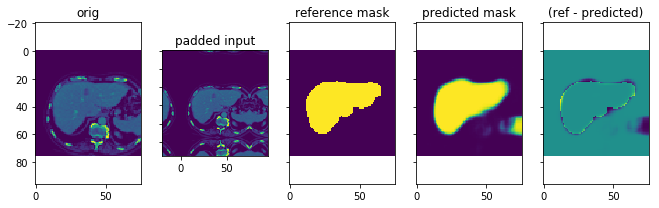

300/300 [==============================] - 1s 4ms/sample - loss: 1.3826
Epoch 29/50
280/300 [===========================>..] - ETA: 0s - loss: 1.2723

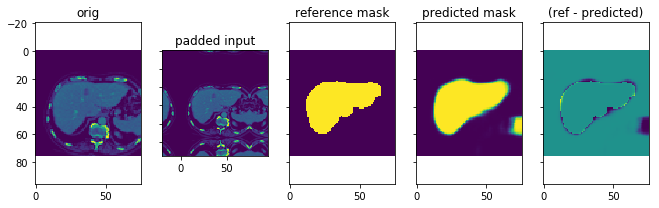

300/300 [==============================] - 1s 4ms/sample - loss: 1.2727
Epoch 30/50
280/300 [===========================>..] - ETA: 0s - loss: 1.3096

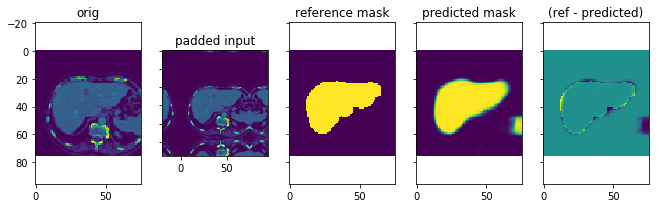

300/300 [==============================] - 1s 4ms/sample - loss: 1.3172
Epoch 31/50
280/300 [===========================>..] - ETA: 0s - loss: 1.3217

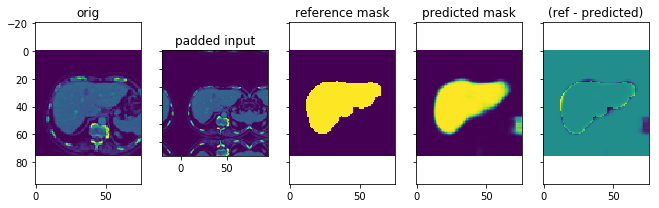

300/300 [==============================] - 1s 4ms/sample - loss: 1.2973
Epoch 32/50
280/300 [===========================>..] - ETA: 0s - loss: 1.2253

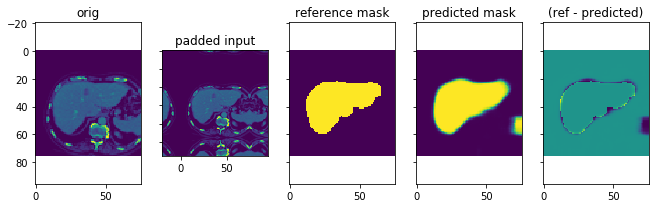

300/300 [==============================] - 1s 4ms/sample - loss: 1.2184
Epoch 33/50
280/300 [===========================>..] - ETA: 0s - loss: 1.2237

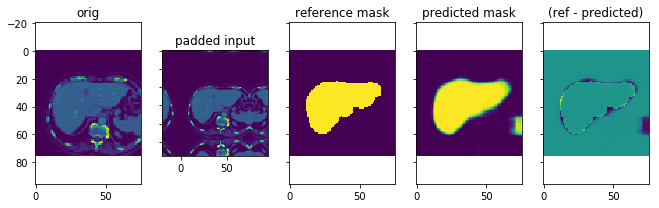

300/300 [==============================] - 1s 4ms/sample - loss: 1.2184
Epoch 34/50
280/300 [===========================>..] - ETA: 0s - loss: 1.1337

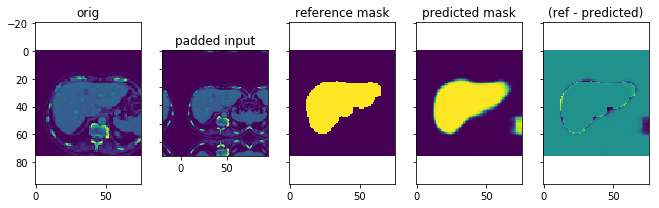

300/300 [==============================] - 1s 4ms/sample - loss: 1.1348
Epoch 35/50
280/300 [===========================>..] - ETA: 0s - loss: 1.1246

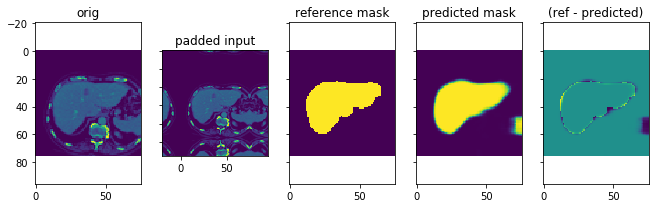

300/300 [==============================] - 1s 4ms/sample - loss: 1.1106
Epoch 36/50
280/300 [===========================>..] - ETA: 0s - loss: 1.1368

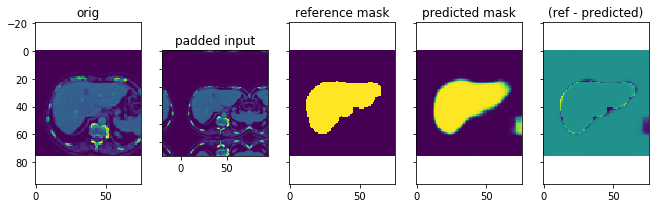

300/300 [==============================] - 1s 4ms/sample - loss: 1.1584
Epoch 37/50
280/300 [===========================>..] - ETA: 0s - loss: 1.1072

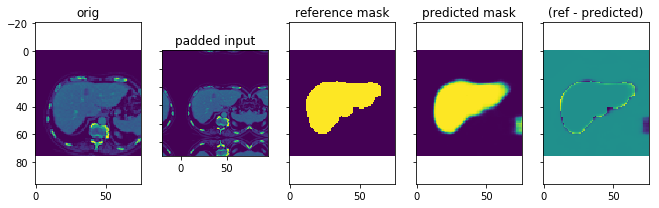

300/300 [==============================] - 1s 4ms/sample - loss: 1.1082
Epoch 38/50
280/300 [===========================>..] - ETA: 0s - loss: 1.0746

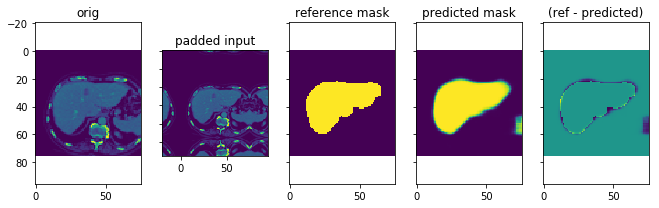

300/300 [==============================] - 1s 4ms/sample - loss: 1.0897
Epoch 39/50
280/300 [===========================>..] - ETA: 0s - loss: 1.1031

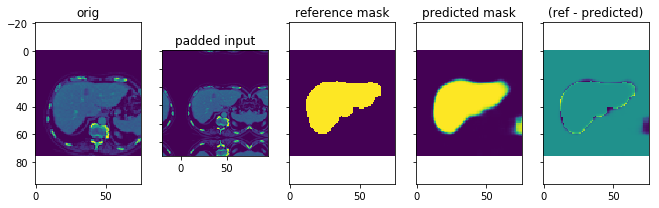

300/300 [==============================] - 1s 4ms/sample - loss: 1.0994
Epoch 40/50
280/300 [===========================>..] - ETA: 0s - loss: 1.0420

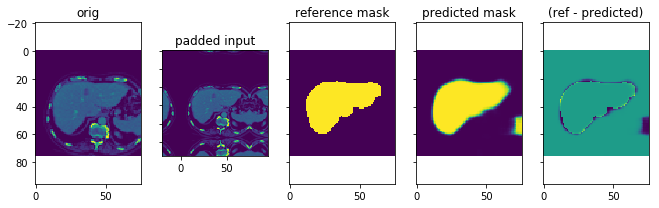

300/300 [==============================] - 1s 4ms/sample - loss: 1.0266
Epoch 41/50
280/300 [===========================>..] - ETA: 0s - loss: 1.0889

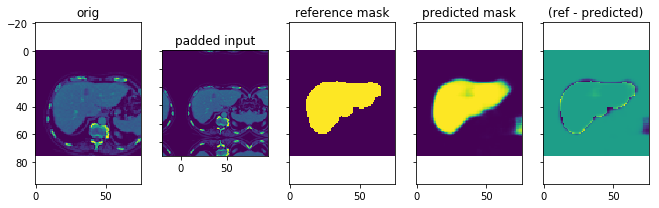

300/300 [==============================] - 1s 4ms/sample - loss: 1.1015
Epoch 42/50
280/300 [===========================>..] - ETA: 0s - loss: 1.0864

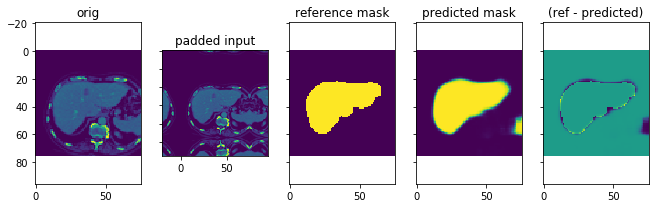

300/300 [==============================] - 1s 4ms/sample - loss: 1.0840
Epoch 43/50
280/300 [===========================>..] - ETA: 0s - loss: 1.0711

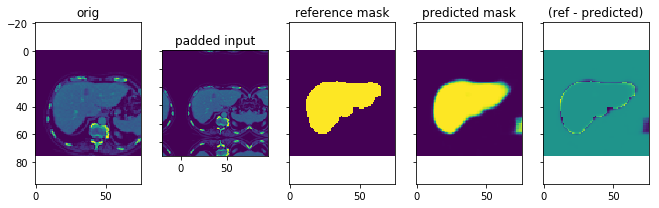

300/300 [==============================] - 1s 4ms/sample - loss: 1.0588
Epoch 44/50
280/300 [===========================>..] - ETA: 0s - loss: 0.9780

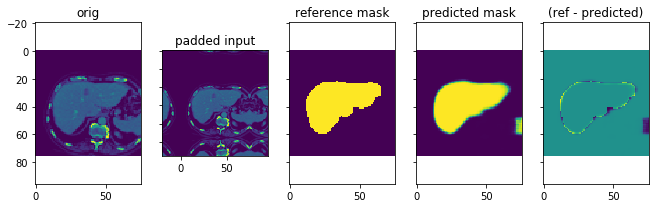

300/300 [==============================] - 1s 4ms/sample - loss: 1.0003
Epoch 45/50
280/300 [===========================>..] - ETA: 0s - loss: 1.0591

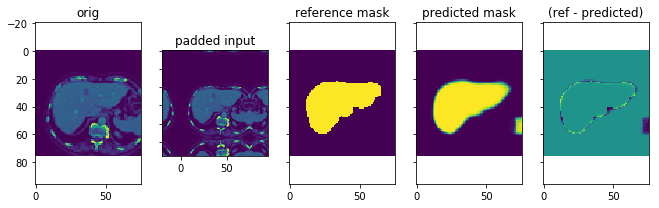

300/300 [==============================] - 1s 4ms/sample - loss: 1.0459
Epoch 46/50
280/300 [===========================>..] - ETA: 0s - loss: 0.9722

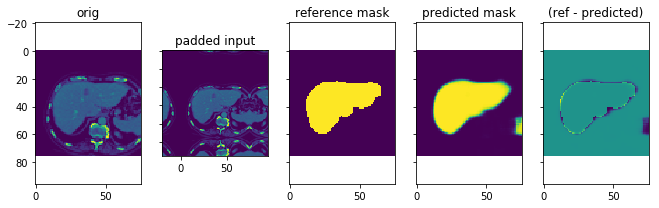

300/300 [==============================] - 1s 4ms/sample - loss: 0.9778
Epoch 47/50
280/300 [===========================>..] - ETA: 0s - loss: 1.0394

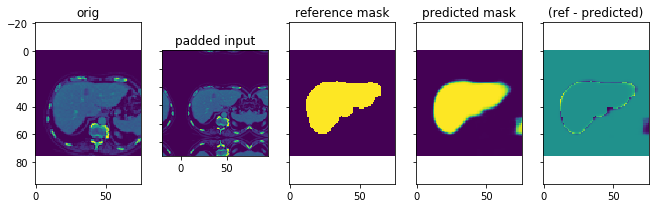

300/300 [==============================] - 1s 4ms/sample - loss: 1.0272
Epoch 48/50
280/300 [===========================>..] - ETA: 0s - loss: 1.0258

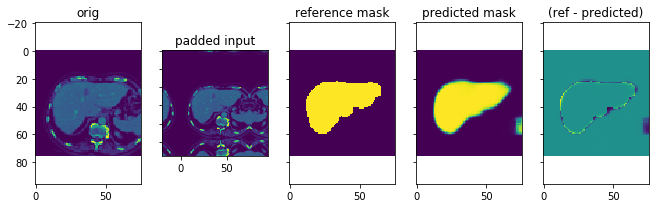

300/300 [==============================] - 1s 4ms/sample - loss: 1.0244
Epoch 49/50
280/300 [===========================>..] - ETA: 0s - loss: 0.9741

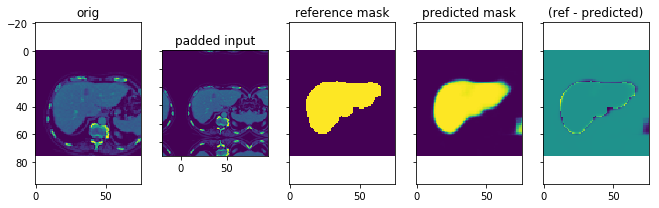

300/300 [==============================] - 1s 4ms/sample - loss: 0.9661
Epoch 50/50
280/300 [===========================>..] - ETA: 0s - loss: 0.9641

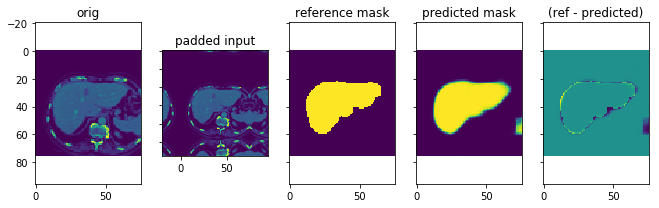

300/300 [==============================] - 1s 4ms/sample - loss: 0.9574


In [34]:
# This is for _padding = 'valid' and 'reflect' padding
historyValid = modelValid.fit(np.lib.pad(x_train[...,np.newaxis],
                                         [(0,0), (20,20), (20,20), (0,0)], 'reflect'),
                              y_train_binary[...,np.newaxis],
                              batch_size=20, epochs=50, callbacks=[vh_callback])

### Dropout Uncertainty

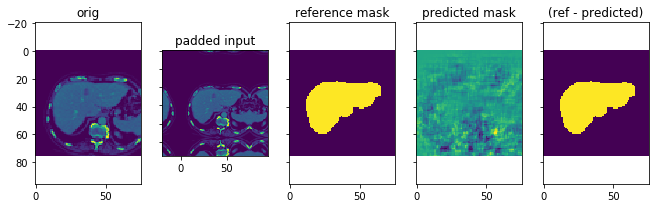

Epoch 1/50
280/300 [===========================>..] - ETA: 0s - loss: 13.1671

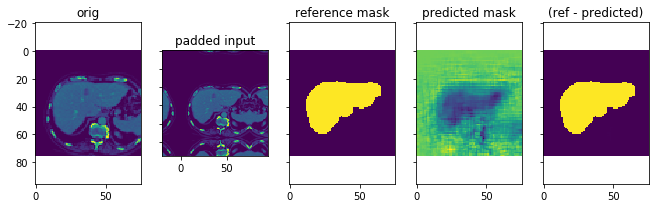

300/300 [==============================] - 4s 14ms/sample - loss: 13.0323
Epoch 2/50
280/300 [===========================>..] - ETA: 0s - loss: 9.9932 

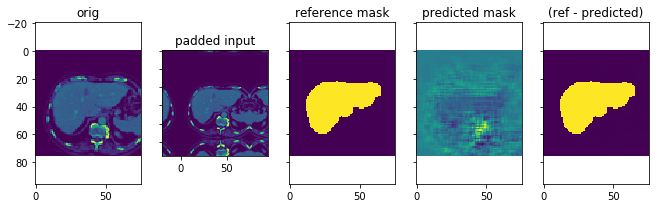

300/300 [==============================] - 2s 5ms/sample - loss: 9.9404
Epoch 3/50
280/300 [===========================>..] - ETA: 0s - loss: 8.7494

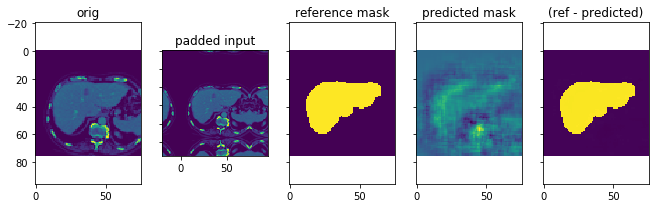

300/300 [==============================] - 1s 5ms/sample - loss: 8.6781
Epoch 4/50
280/300 [===========================>..] - ETA: 0s - loss: 6.9899

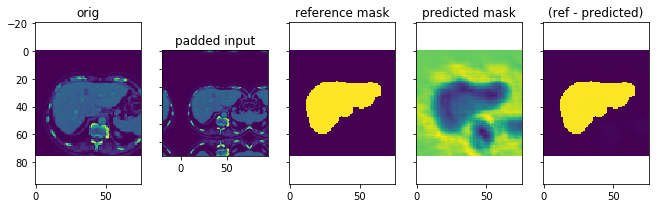

300/300 [==============================] - 1s 5ms/sample - loss: 7.0573
Epoch 5/50
280/300 [===========================>..] - ETA: 0s - loss: 6.3380

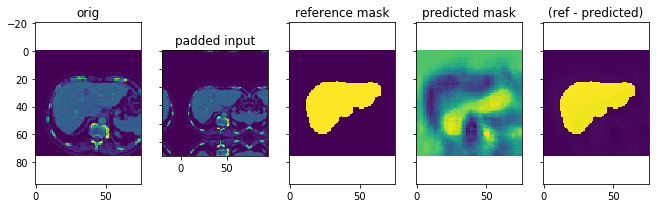

300/300 [==============================] - 2s 5ms/sample - loss: 6.2589
Epoch 6/50
280/300 [===========================>..] - ETA: 0s - loss: 5.2991

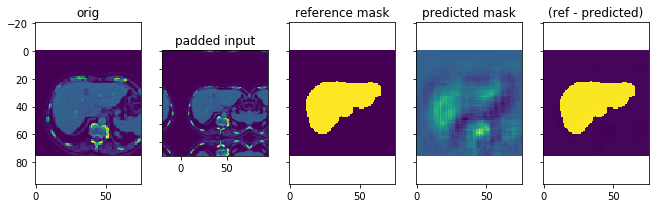

300/300 [==============================] - 2s 5ms/sample - loss: 5.2438
Epoch 7/50
 40/300 [===>..........................] - ETA: 0s - loss: 4.3938

KeyboardInterrupt: 

In [38]:
# This is for _padding = 'valid' and 'reflect' padding
historyBayesValid = modelBayesValid.fit(np.lib.pad(x_train[...,np.newaxis],
                                         [(0,0), (20,20), (20,20), (0,0)], 'reflect'),
                              y_train_binary[...,np.newaxis],
                              batch_size=20, epochs=50, callbacks=[vh_callback])

### Probabilistic Conv2D layers

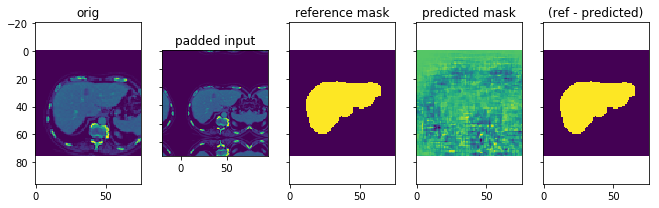

Epoch 1/50
280/300 [===========================>..] - ETA: 0s - loss: 2672.9461

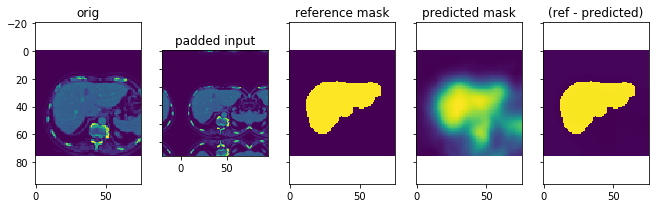

300/300 [==============================] - 4s 13ms/sample - loss: 2672.2691
Epoch 2/50
280/300 [===========================>..] - ETA: 0s - loss: 2653.4290

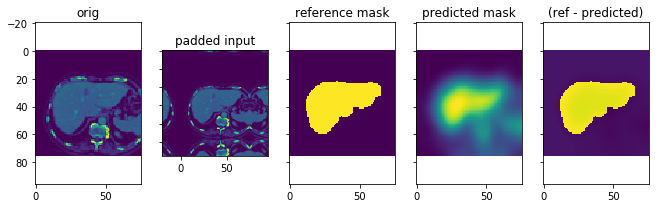

300/300 [==============================] - 1s 5ms/sample - loss: 2652.8226
Epoch 3/50
280/300 [===========================>..] - ETA: 0s - loss: 2635.5626

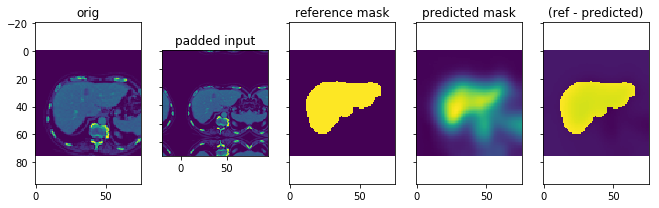

300/300 [==============================] - 1s 5ms/sample - loss: 2634.9745
Epoch 4/50
280/300 [===========================>..] - ETA: 0s - loss: 2618.5376

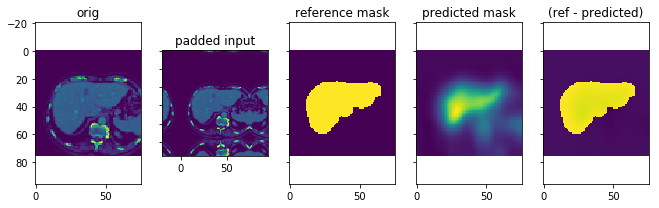

300/300 [==============================] - 2s 5ms/sample - loss: 2617.9694
Epoch 5/50
280/300 [===========================>..] - ETA: 0s - loss: 2602.0773

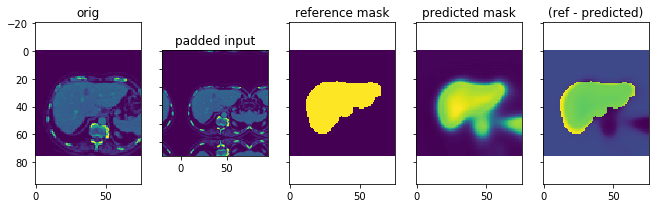

300/300 [==============================] - 1s 5ms/sample - loss: 2601.5431
Epoch 6/50
220/300 [=====================>........] - ETA: 0s - loss: 2587.5202

KeyboardInterrupt: 

In [42]:
# This is for _padding = 'valid' and 'reflect' padding
historyProbBayesValid = model_ProbBayes.fit(np.lib.pad(x_train[...,np.newaxis],
                                         [(0,0), (20,20), (20,20), (0,0)], 'reflect'),
                              y_train_binary[...,np.newaxis],
                              batch_size=20, epochs=50, callbacks=[vh_callback])

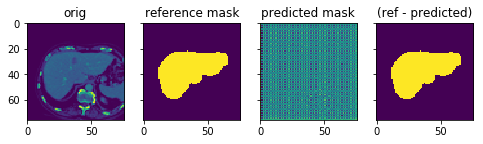

Epoch 1/50
280/300 [===========================>..] - ETA: 0s - loss: 91.6235

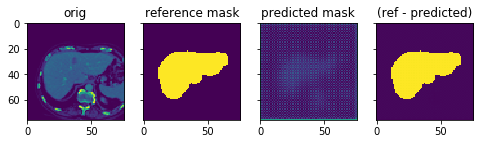

300/300 [==============================] - 1s 4ms/sample - loss: 91.4474
Epoch 2/50
280/300 [===========================>..] - ETA: 0s - loss: 88.3591

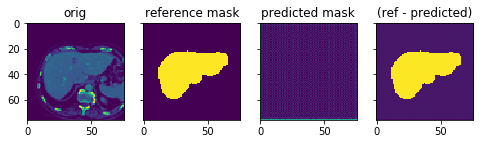

300/300 [==============================] - 1s 4ms/sample - loss: 88.2509
Epoch 3/50
280/300 [===========================>..] - ETA: 0s - loss: 86.6404

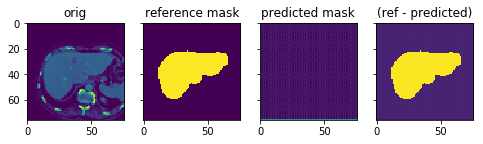

300/300 [==============================] - 1s 4ms/sample - loss: 86.5878
Epoch 4/50
280/300 [===========================>..] - ETA: 0s - loss: 84.9829

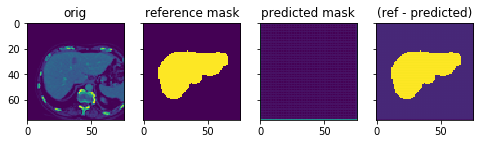

300/300 [==============================] - 1s 4ms/sample - loss: 84.8750
Epoch 5/50
280/300 [===========================>..] - ETA: 0s - loss: 83.5605

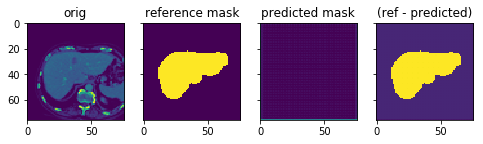

300/300 [==============================] - 1s 4ms/sample - loss: 83.4937
Epoch 6/50
280/300 [===========================>..] - ETA: 0s - loss: 82.3593

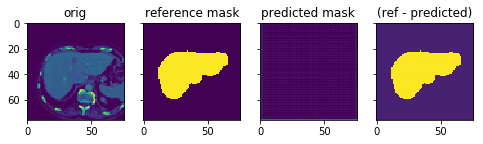

300/300 [==============================] - 1s 5ms/sample - loss: 82.2725
Epoch 7/50
280/300 [===========================>..] - ETA: 0s - loss: 81.3937

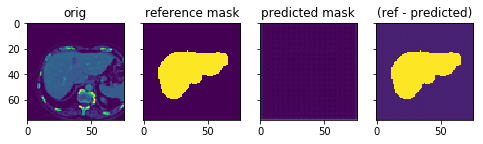

300/300 [==============================] - 1s 5ms/sample - loss: 81.3410
Epoch 8/50
280/300 [===========================>..] - ETA: 0s - loss: 80.2823

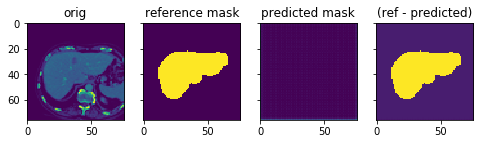

300/300 [==============================] - 2s 5ms/sample - loss: 80.2261
Epoch 9/50
280/300 [===========================>..] - ETA: 0s - loss: 79.7018

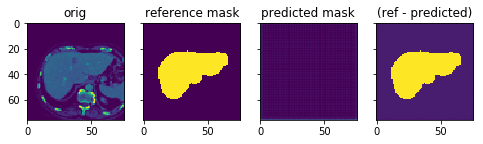

300/300 [==============================] - 1s 4ms/sample - loss: 79.6456
Epoch 10/50
280/300 [===========================>..] - ETA: 0s - loss: 78.8734

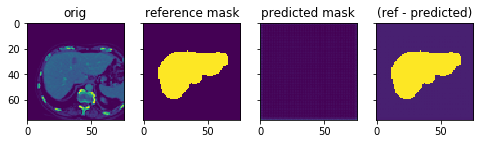

300/300 [==============================] - 2s 6ms/sample - loss: 78.8398
Epoch 11/50
280/300 [===========================>..] - ETA: 0s - loss: 78.1823

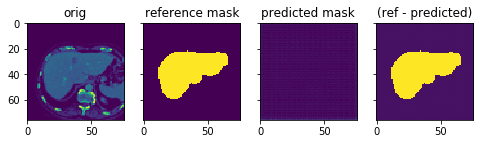

300/300 [==============================] - 1s 4ms/sample - loss: 78.1514
Epoch 12/50
280/300 [===========================>..] - ETA: 0s - loss: 77.6289

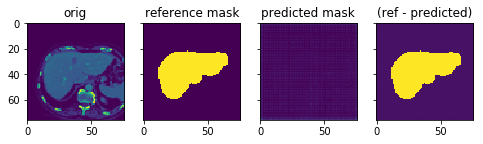

300/300 [==============================] - 1s 4ms/sample - loss: 77.5995
Epoch 13/50
280/300 [===========================>..] - ETA: 0s - loss: 77.0617

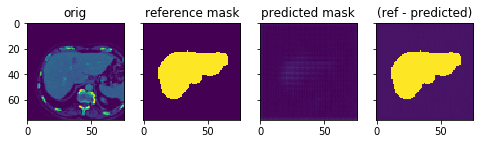

300/300 [==============================] - 1s 4ms/sample - loss: 77.0247
Epoch 14/50
280/300 [===========================>..] - ETA: 0s - loss: 76.4512

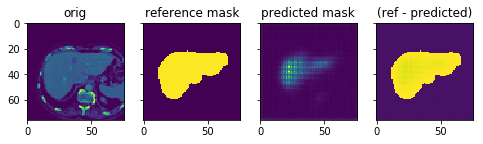

300/300 [==============================] - 1s 4ms/sample - loss: 76.4695
Epoch 15/50
280/300 [===========================>..] - ETA: 0s - loss: 76.0013

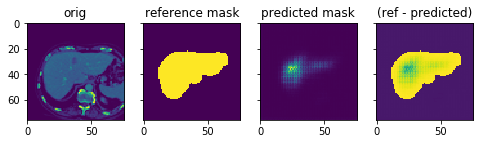

300/300 [==============================] - 1s 4ms/sample - loss: 75.9887
Epoch 16/50
280/300 [===========================>..] - ETA: 0s - loss: 75.2542

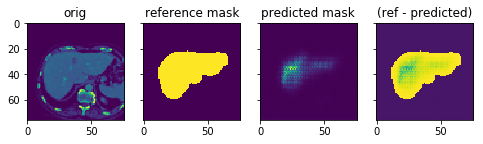

300/300 [==============================] - 2s 5ms/sample - loss: 75.2317
Epoch 17/50
280/300 [===========================>..] - ETA: 0s - loss: 74.7446

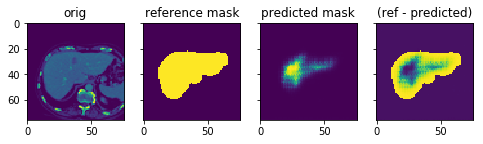

300/300 [==============================] - 2s 5ms/sample - loss: 74.7259
Epoch 18/50
280/300 [===========================>..] - ETA: 0s - loss: 74.2322

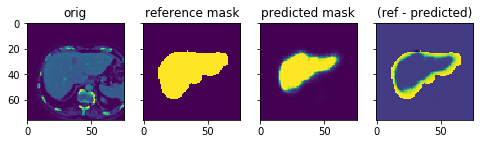

300/300 [==============================] - 1s 4ms/sample - loss: 74.2255
Epoch 19/50
280/300 [===========================>..] - ETA: 0s - loss: 73.8502

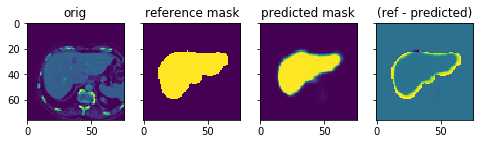

300/300 [==============================] - 1s 4ms/sample - loss: 73.8247
Epoch 20/50
280/300 [===========================>..] - ETA: 0s - loss: 73.2470

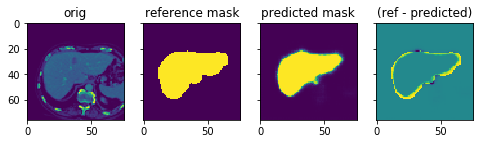

300/300 [==============================] - 1s 4ms/sample - loss: 73.2261
Epoch 21/50
280/300 [===========================>..] - ETA: 0s - loss: 72.7059

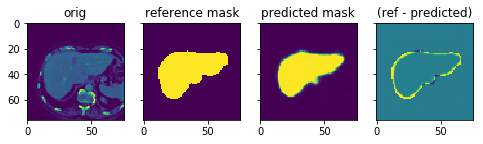

300/300 [==============================] - 1s 5ms/sample - loss: 72.7084
Epoch 22/50
280/300 [===========================>..] - ETA: 0s - loss: 72.1933

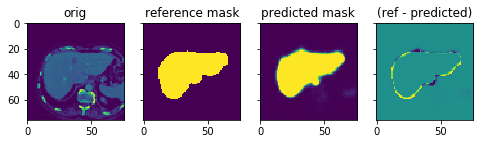

300/300 [==============================] - 1s 4ms/sample - loss: 72.1738
Epoch 23/50
280/300 [===========================>..] - ETA: 0s - loss: 71.6619

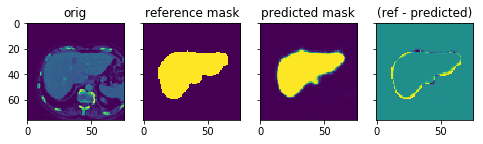

300/300 [==============================] - 1s 4ms/sample - loss: 71.6420
Epoch 24/50
260/300 [=========================>....] - ETA: 0s - loss: 71.2540

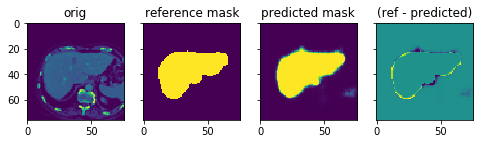

300/300 [==============================] - 1s 4ms/sample - loss: 71.2205
Epoch 25/50
280/300 [===========================>..] - ETA: 0s - loss: 70.7023

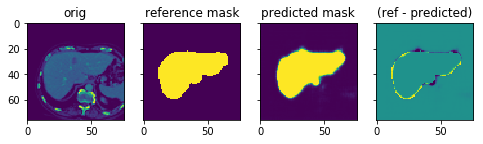

300/300 [==============================] - 1s 4ms/sample - loss: 70.6824
Epoch 26/50
280/300 [===========================>..] - ETA: 0s - loss: 70.3357

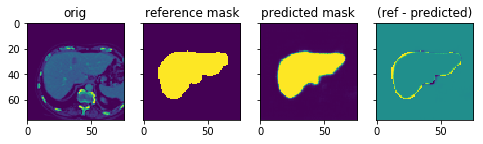

300/300 [==============================] - 2s 5ms/sample - loss: 70.3150
Epoch 27/50
280/300 [===========================>..] - ETA: 0s - loss: 69.8312

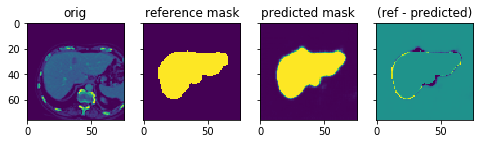

300/300 [==============================] - 1s 4ms/sample - loss: 69.8166
Epoch 28/50
280/300 [===========================>..] - ETA: 0s - loss: 69.2985

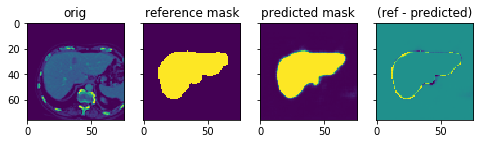

300/300 [==============================] - 1s 4ms/sample - loss: 69.2755
Epoch 29/50
280/300 [===========================>..] - ETA: 0s - loss: 68.8057

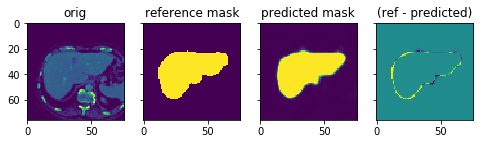

300/300 [==============================] - 1s 4ms/sample - loss: 68.7908
Epoch 30/50
280/300 [===========================>..] - ETA: 0s - loss: 68.3097

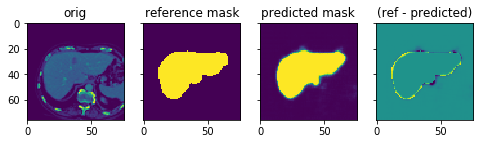

300/300 [==============================] - 1s 4ms/sample - loss: 68.2880
Epoch 31/50
280/300 [===========================>..] - ETA: 0s - loss: 67.8134

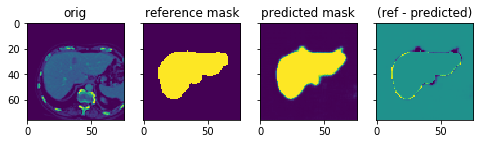

300/300 [==============================] - 1s 4ms/sample - loss: 67.7953
Epoch 32/50
280/300 [===========================>..] - ETA: 0s - loss: 67.3036

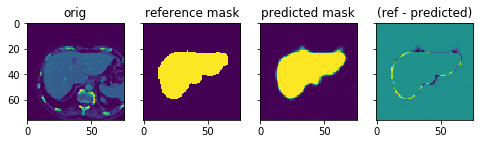

300/300 [==============================] - 1s 4ms/sample - loss: 67.2823
Epoch 33/50
280/300 [===========================>..] - ETA: 0s - loss: 66.8003

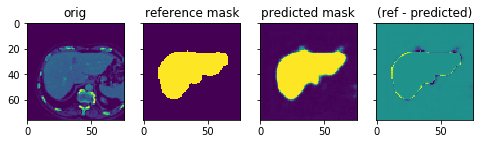

300/300 [==============================] - 1s 5ms/sample - loss: 66.7794
Epoch 34/50
280/300 [===========================>..] - ETA: 0s - loss: 66.3417

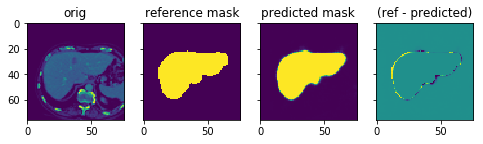

300/300 [==============================] - 1s 4ms/sample - loss: 66.3253
Epoch 35/50
280/300 [===========================>..] - ETA: 0s - loss: 65.8925

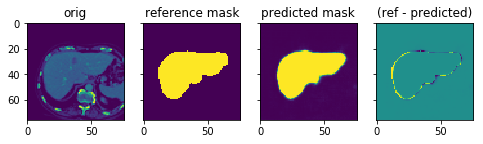

300/300 [==============================] - 2s 5ms/sample - loss: 65.8797
Epoch 36/50
280/300 [===========================>..] - ETA: 0s - loss: 65.4464

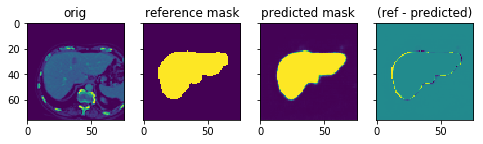

300/300 [==============================] - 1s 4ms/sample - loss: 65.4294
Epoch 37/50
280/300 [===========================>..] - ETA: 0s - loss: 64.9743

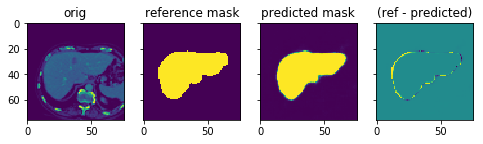

300/300 [==============================] - 1s 4ms/sample - loss: 64.9782
Epoch 38/50
280/300 [===========================>..] - ETA: 0s - loss: 64.4825

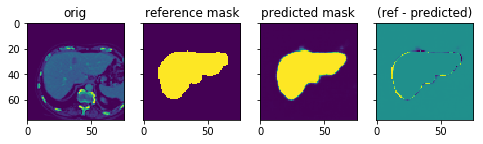

300/300 [==============================] - 1s 5ms/sample - loss: 64.4780
Epoch 39/50
280/300 [===========================>..] - ETA: 0s - loss: 64.0692

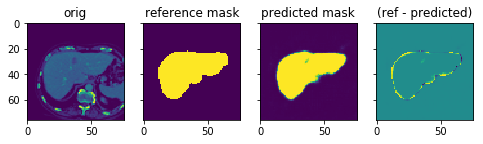

300/300 [==============================] - 1s 4ms/sample - loss: 64.0508
Epoch 40/50
280/300 [===========================>..] - ETA: 0s - loss: 63.6462

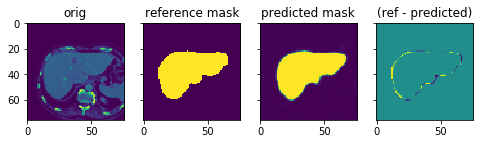

300/300 [==============================] - 1s 5ms/sample - loss: 63.6281
Epoch 41/50
280/300 [===========================>..] - ETA: 0s - loss: 63.1211

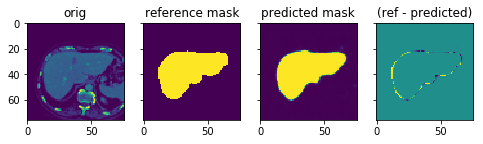

300/300 [==============================] - 1s 4ms/sample - loss: 63.0990
Epoch 42/50
280/300 [===========================>..] - ETA: 0s - loss: 62.6173

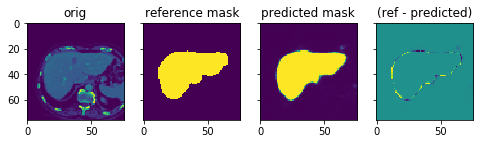

300/300 [==============================] - 1s 4ms/sample - loss: 62.5990
Epoch 43/50
280/300 [===========================>..] - ETA: 0s - loss: 62.0971

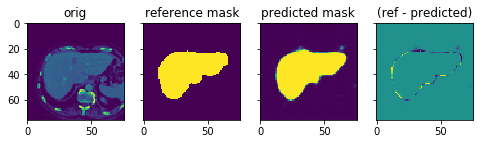

300/300 [==============================] - 1s 4ms/sample - loss: 62.0797
Epoch 44/50
280/300 [===========================>..] - ETA: 0s - loss: 61.6574

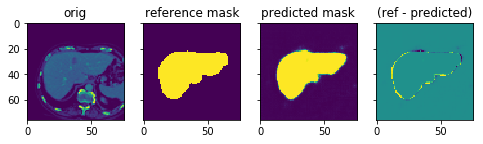

300/300 [==============================] - 1s 4ms/sample - loss: 61.6495
Epoch 45/50
280/300 [===========================>..] - ETA: 0s - loss: 61.2252

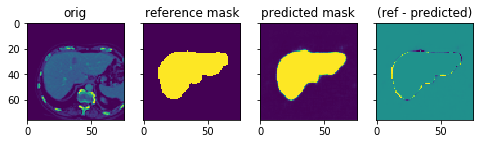

300/300 [==============================] - 1s 4ms/sample - loss: 61.2120
Epoch 46/50
280/300 [===========================>..] - ETA: 0s - loss: 60.7221

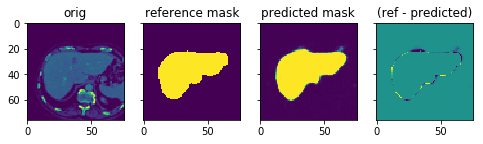

300/300 [==============================] - 1s 4ms/sample - loss: 60.7036
Epoch 47/50
280/300 [===========================>..] - ETA: 0s - loss: 60.2534

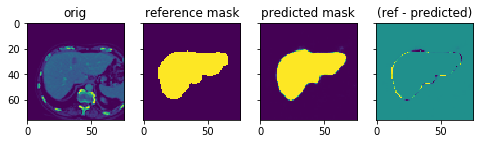

300/300 [==============================] - 1s 4ms/sample - loss: 60.2355
Epoch 48/50
280/300 [===========================>..] - ETA: 0s - loss: 59.7935

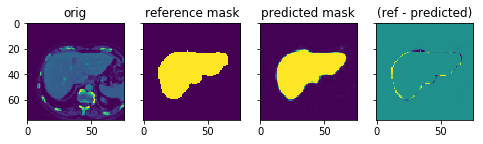

300/300 [==============================] - 1s 4ms/sample - loss: 59.7792
Epoch 49/50
280/300 [===========================>..] - ETA: 0s - loss: 59.3196

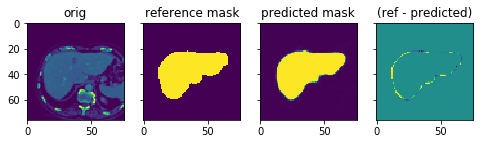

300/300 [==============================] - 1s 4ms/sample - loss: 59.3098
Epoch 50/50
280/300 [===========================>..] - ETA: 0s - loss: 58.8711

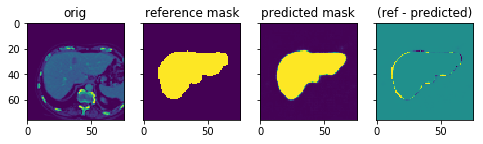

300/300 [==============================] - 2s 6ms/sample - loss: 58.8547


In [77]:
# This is for _padding = 'valid' and 'reflect' padding.
# Model needs no padding even for "valid"
historyProbBayesModernValid = model_ProbBayesModern.fit(x_train[...,np.newaxis],
                              y_train_binary[...,np.newaxis],
                              batch_size=20, epochs=50, callbacks=[vh_callback])

## Prediction using Bayes by Dropout on the initial model

For this approach, the prediction needs to run $n$ times, averaging the results per voxel for the final prediction.

Warning: this unconditionally puts all layers into training mode, also the BatchNormalization, which will lead to side effects. 


In [40]:
# Define a prediction function from the model, setting the learning phase to "learn" to let dropout be active.
f = K.function([modelValid.layers[0].input, K.learning_phase()],
               [modelValid.layers[-1].output])

# This takes some memory. In my example, all 566 test images won't be processed on a 4GB GPU.
def predict_with_uncertainty(f, x, no_classes, n_iter=20):
    result = np.zeros( (n_iter,) + (x.shape) + (no_classes,) )

    for i in range(n_iter):
        result[i,:, :] = f((x, 1))[0]
    prediction = result.mean(axis=0)
    uncertainty = result.std(axis=0)
    return prediction, uncertainty, result    

In [107]:
x_test0 = x_test[0:2][...,np.newaxis]

print(x_test0.shape, len(x_test0))

(2, 76, 76, 1) 2


In [108]:
x_test0 = pad_image_for_model(modelValid, x_test0)
result = np.zeros((20,) + (len(x_test0),) + (x_test[0].shape) + (1,) )

In [109]:
print(len(f((x_test0,1))),f((x_test0,1))[0].shape)

1 (2, 76, 76, 1)


In [110]:
for i in range(20):
    result[i,:,:,:] = f((x_test0,1))[0]
    
print(result.shape)

(20, 2, 76, 76, 1)


In [125]:
y_pred0 = do_prediction(modelValid, x_test[0])
y_pred1 = do_prediction(modelValid, x_test[1])
y_pred0[2].shape

(1, 76, 76, 1)

In [111]:
prediction = result.mean(axis=0)
uncertainty = result.std(axis=0)
print(prediction.shape, uncertainty.shape)

(2, 76, 76, 1) (2, 76, 76, 1)


In [131]:
def plot_result(in_image, in_mask, direct_prediction, prob_prediction, uncertainty):
    f, ax = plt.subplots(1, 5, figsize = (22, 6), sharey = True)
    ax[0].imshow(in_image)
    ax[0].set_title('orig')
    ax[1].imshow(in_mask)
    ax[1].set_title('mask')
    ax[2].imshow(direct_prediction)
    ax[2].set_title('mask')
    ax[3].imshow(prob_prediction)
    ax[3].set_title('prob. prediction')
    ax[4].imshow(uncertainty)
    ax[4].set_title('uncertainty')
    plt.show()

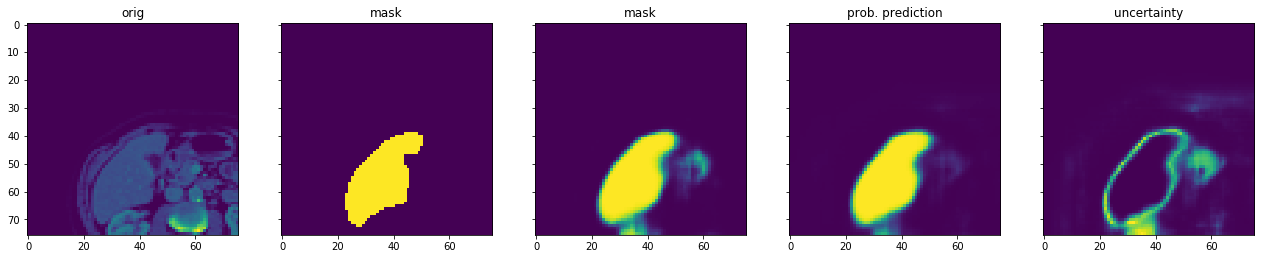

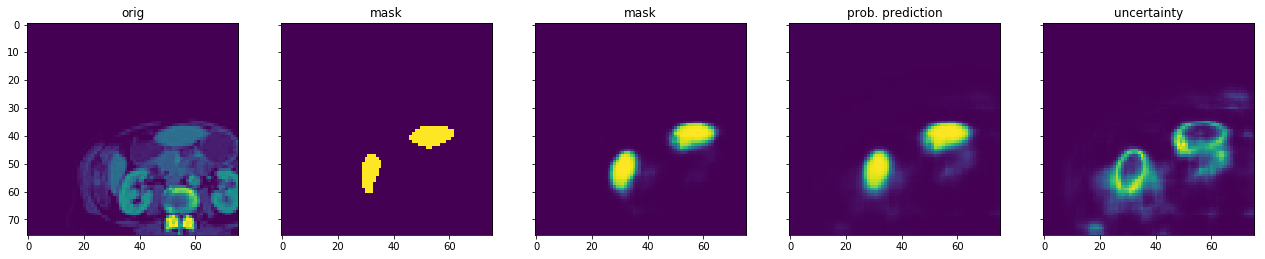

In [132]:
plot_result(x_test[0], y_test[0], y_pred0[2][0,:,:,0], prediction[0,:,:,0],uncertainty[0,:,:,0])
plot_result(x_test[1], y_test[1], y_pred1[2][0,:,:,0], prediction[1,:,:,0],uncertainty[1,:,:,0])

## Prediction
Let's look at the prediction from some more example slices, but let's only use the `x_test` slices that we did not use for training. (In a real scenario, we would to the separation of training & test data on the level of patients, *before* extracting slices, and we'd also have a validation set.)

In [18]:
slice_indices = np.random.choice(x_test.shape[0], 6)

### Evaluate model with 'valid' convolutions

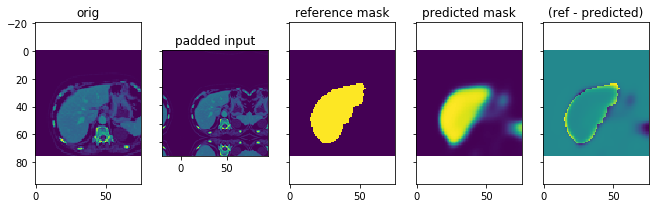

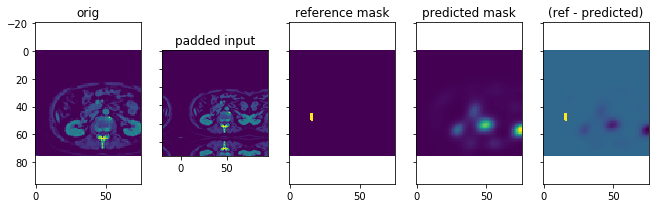

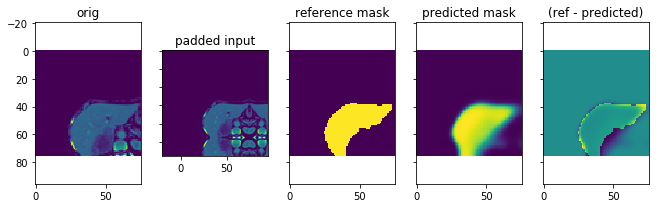

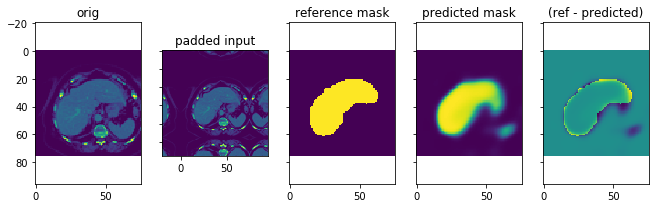

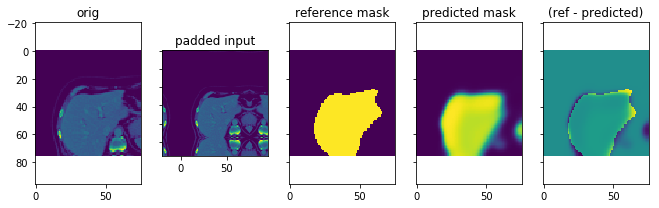

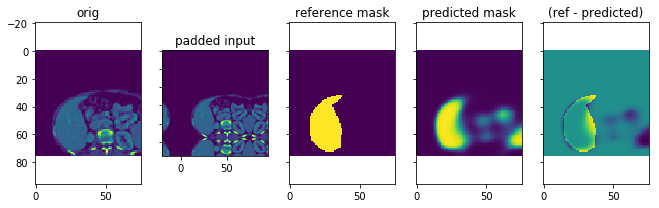

In [19]:
for a in slice_indices:
    plot_prediction(modelValid, a)

### Evaluate model with 'same' convolutions

In [ ]:
for a in slice_indices:
    plot_prediction(modelSame, a)

### Tile-based Prediction

Let's predict the image divided into upper and lower half, and then in full. Note that the network could also predict smaller or larger tile sizes.  Such an approach is necessary for large images, or with volumetric data and 3D convolutions, when it is not possible to have the whole image in (GPU) memory at the same time.

In [ ]:
# hand-picked slice useful to visualize benefits of tiled approach
example_test_slice = 505 - TRAINING_SLICE_COUNT
assert example_test_slice > 0, 'when increasing TRAINING_SLICE_COUNT, please pick a new example slice as well'


def plot_prediction_tiled(model, pred_slice_index, tile = None):
    # get single slice
    input_image    = x_train[pred_slice_index]
    reference_mask = y_train_binary[pred_slice_index]

    # first do padding of full slice
    input_image, padding = pad_image_for_model(model, input_image)
    
    # add batch and channel dimensions (network expects 4D arrays)
    input_array = input_image[np.newaxis,:,:,np.newaxis]
    print("padded input shape:", input_array.shape)

    # then cut the specified tile box (plus padding)
    if tile is not None: # (default is full slice)
        tile = np.asarray(tile)
        assert tile.shape == (2, 2)
        padded_tile = tile.copy()
        padded_tile[:,1] += 2*padding
        input_array = input_array[:,
                                  padded_tile[0][0]:padded_tile[0][1],
                                  padded_tile[1][0]:padded_tile[1][1],
                                  :]
        reference_mask = reference_mask[tile[0][0]:tile[0][1],
                                        tile[1][0]:tile[1][1]]
        print("tiled padded shape:", input_array.shape)

    y_predicted = model.predict(input_array)
    print("output shape:", y_predicted.shape)

    padded_extent = np.array([0,input_array.shape[2],input_array.shape[1],0]) - 0.5 - padding
    orig_extent = np.array([0,reference_mask.shape[1],reference_mask.shape[0],0]) - 0.5
    if tile is not None:
        padded_extent[:2] += tile[1,0]
        padded_extent[2:] += tile[0,0]
        orig_extent[:2] += tile[1,0]
        orig_extent[2:] += tile[0,0]

    # display prediction for inspection
    f, ax = plt.subplots(1, 4 if padding else 3, figsize = (14 if padding else 12, 3), sharey = True)
    ax[0].imshow(x_train[pred_slice_index])
    ax[0].set_title('orig')
    if padding:
        ax[1].imshow(input_array[0,:,:,0], extent = padded_extent)
        ax[1].set_title('padded input')
    ax[-2].imshow(y_predicted[0,:,:,0], extent = orig_extent)
    ax[-2].set_title('predicted mask')
    ax[-1].imshow(reference_mask, extent = orig_extent)
    ax[-1].set_title('reference mask')
    ax[0].set_ylim(*padded_extent[2:])
    plt.show()

In [ ]:
tile = [[0,42],[0,76]]
plot_prediction_tiled(modelSame, example_test_slice, tile)
tile = [[42,76],[0,76]]
plot_prediction_tiled(modelSame, example_test_slice, tile)
plot_prediction(modelSame, example_test_slice)

In [ ]:
tile = [[0,42],[0,76]]
plot_prediction_tiled(modelValid, example_test_slice, tile)
tile = [[42,76],[0,76]]
plot_prediction_tiled(modelValid, example_test_slice, tile)
plot_prediction(modelValid, example_test_slice)

## Regularisation
* Regularisation should improve convergence. Let's try and add some Batch Normalisation first. Batch Normalisation intends to normalise the input to a (convolutional) layer, so that the values in the resulting feature maps don't get exessively large. 
    * Keras offers BatchNorm layers.
    * Include one before each convolutional layer.
* Another regularisation measure is to choose better activation functions. Probabilistic Rectified Linear Units (PReLU) crop negative values to a small epsilon, but route through any value greater than zero.
    * In Keras, activation functions are selected through the `activation=[softmax|elu|selu|relu|tanh|sigmoid|hard_sigmoid|linear]` parameter to a layer, each in quotes.
    * PReLU is one of the advanced activation functions that need to be added as a layer. It has many "trainable" parameters. How many? Why?
    * How many parameters does ReLU have?
* Lastly, L1 and L2 norm can be used as additional constraints on weights, biases, and activations.
    * In Keras, this normalisation is again a parameter to the layer initialisation, using `kernel_regularizer=[l1(0.01)|l2(0.01)|l1_l2(0.01)]`.
    * You have to `from keras.regularizers import l1, l2, l1_l2` to enable this functionality.
    * You can also explore `bias_regularizer` and `activity_regularizer`.
* Make your life easier by extracting a block: Conv -- Relu -- Batch Normalization. Then play with the options -- but carefully: When you just switch everything "on", chances are you will get bad results...

In [ ]:
# We will use the following block to generate the regularisation block

from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU

def addConvBN(model, filters=32, kernel_size=(3,3), batch_norm=True, activation='prelu', padding='same', kernel_regularizer=None, name = None):
    if batch_norm:
        model.add(BatchNormalization())
    if activation == 'prelu':
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='linear', kernel_regularizer=kernel_regularizer, name = name))
        model.add(PReLU())
    elif activation == 'lrelu':
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='linear', kernel_regularizer=kernel_regularizer, name = name))
        model.add(LeakyReLU())
    else:
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation, kernel_regularizer=kernel_regularizer, name = name))

In [ ]:
# batch norm model
def getBNModel(_filters=32, _filters_add=0, _kernel_size=(3,3), _padding='same', _activation='prelu', _kernel_regularizer=None, _final_layer_nonlinearity='sigmoid', _num_classes=1):
    model = Sequential()
    
    # this is really ugly, but TensorFlow's batch normalization
    # currently has a limitation that it cannot work on unknown input sizes,
    # so we need to get the height & width of our training data:
    h, w = x_train.shape[1:]
    if _padding == 'valid':
        model.add(InputLayer(input_shape = (h+40, w+40, 1)))
    elif _padding == 'same':
        model.add(InputLayer(input_shape = (h, w, 1)))

    addConvBN(model, filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, name='firstConvolutionalLayer')
    addConvBN(model, filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)
    model.add(MaxPool2D())

    addConvBN(model, filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)
    addConvBN(model, filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)
    model.add(MaxPool2D())

    addConvBN(model, filters=_filters+2*_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)
    addConvBN(model, filters=_filters+2*_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)
    model.add(UpSampling2D())

    addConvBN(model, filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)
    addConvBN(model, filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)
    model.add(UpSampling2D())

    addConvBN(model, filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)
    addConvBN(model, filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer)

    model.add(Conv2D(_num_classes, kernel_size=(1,1), activation=_final_layer_nonlinearity))
    return model

### Batch Norm with PReLU

In [ ]:
# This network uses the PReLU layer.
# Note the number of parameters when executing model.summary().
modelValidBN = getBNModel(_padding='valid')
modelValidBN.compile(loss='binary_crossentropy', optimizer='adam')
modelValidBN.summary()

In [ ]:
padded_x_train, padding = pad_image_for_model(modelValidBN, x_train[...,np.newaxis])
historyValidBN = modelValidBN.fit(padded_x_train,
                                  y_train_binary[...,np.newaxis],
                                  batch_size=10, epochs=5, callbacks=[vh_callback])

In [ ]:
fig,ax = plt.subplots(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
ax.plot(historyValid.history['loss'], label = 'without BN')
ax.plot(historyValidBN.history['loss'], label = 'with batch normalization')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid()
ax.legend(loc = 'best')
plt.show()

Alternatively, we could use padded convolutions again:

In [ ]:
modelSameBN = getBNModel(_padding='same')
modelSameBN.compile(loss='binary_crossentropy', optimizer='adam')
history = modelSameBN.fit(x_train[...,np.newaxis], y_train_binary[...,np.newaxis],
                          batch_size=10, epochs=5, callbacks=[vh_callback]) 

### Batch Norm with ReLU

In [ ]:
# Now compare with a model with ReLU (instead of PReLu)
model = getBNModel(_padding='valid', _activation='relu')
model.compile(loss='binary_crossentropy', optimizer='adam')
print("Model parameters: {0:,}".format(model.count_params()))

In [ ]:
padded_x_train, padding = pad_image_for_model(model, x_train[...,np.newaxis])
history = model.fit(padded_x_train, y_train_binary[...,np.newaxis],
                    batch_size=10, epochs=75, callbacks=[vh_callback]) 

### Regularisation using L1/L2 norm on weights

In [ ]:
from keras.regularizers import l1, l2, l1_l2

model = getModel(_padding='valid', _kernel_regularizer = l2(0.001))
model.compile(loss='binary_crossentropy', optimizer='adam')
print("Model parameters: {0:,}".format(model.count_params()))

In [ ]:
padded_x_train, padding = pad_image_for_model(model, x_train[...,np.newaxis])
history = model.fit(padded_x_train,
                    y_train_binary[...,np.newaxis],
                    batch_size=10, epochs=75, callbacks=[vh_callback]) 

# 6. Loss functions
* Loss functions take the predicted output, `y_pred`, and the expected output, `y_train`, and calculate their distance. The result is the minimization target.

## Loss functions: Final layer non-linearity dependency
* We have worked with binary crossentropy. See [this blog series](http://neuralnetworksanddeeplearning.com/chap3.html) for a comment:
    > When should we use the cross-entropy instead of the quadratic cost?<p>In fact, the cross-entropy is nearly always the better choice, provided the output neurons are sigmoid neurons.
* Experiment with different loss functions: `mean_squared_error | logcosh | binary_crossentropy | cosine_proximity`
* Experiment with different final layer nonlinearities: `softmax | elu | selu | relu | tanh | sigmoid | hard_sigmoid | linear`

## Loss Functions: Jaccard
Generally considered a powerful loss is also Jaccard loss; it provides larger errors and therefore more stable gradients close to the solution. $l_j = \frac{\sum |A*B|}{\sum |A| +\sum |B| -\sum |A*B|}$

In practice, we also have to prevent division by zero. The following code uses a smoothing term to avoid exploding or disapearing gradients.

In [ ]:
from keras import backend as K

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    The jaccard distance loss is useful for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

### Train model with Jaccard loss.

In [ ]:
model = getModel()
model.compile(loss=jaccard_distance_loss, optimizer='adam')
print("Model parameters: {0:,}".format(model.count_params()))

padded_x_train, padding = pad_image_for_model(model, x_train[...,np.newaxis])
history = model.fit(padded_x_train, 
                    y_train_binary[...,np.newaxis], 
                    batch_size=10, epochs=75, callbacks=[vh_callback]) 

## Loss Functions: Dice
* For segmentation, the Dice loss is also very common. $l_d = 2*\sum \frac{|A*B|} {\sum A^2 + \sum B^2}$

NB: Jaccard and Dice are very similar overlap measures and can easily be computed from each other (bijection):
<img src="images/jaccard_vs_dice.png">

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    @url: https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

### Train model with Dice loss

In [ ]:
model = getBNModel()
model.compile(loss=dice_coef_loss, optimizer='adadelta')
print("Model parameters: {0:,}".format(model.count_params()))

padded_x_train, padding = pad_image_for_model(model, x_train[...,np.newaxis])
history = model.fit(padded_x_train,
                    y_train_binary[...,np.newaxis],
                    batch_size=10, epochs=75, callbacks=[vh_callback]) 

# Segmentation using a U-Net
* U-Nets are characterized by a downsampling path and an upsamling path, which allow for a pixel-wise output.
* Skip connections are used between them in order to make it easier for the network to retain fine details.
* Below is a diagram of the U-Net we will create now. You'll learn how to create it, too.
<img src="images/U-net_4_levels.png" alt="U-Net diagram"/>

In [ ]:
# We will use this to generate the regularisation block for the sequential model.
def addConvBNSequential(model, filters=32, kernel_size=(3,3), batch_norm=True, activation='prelu', padding='same', kernel_regularizer=None, name=None):
    if batch_norm:
        model = BatchNormalization()(model)
    if activation == 'prelu':
        model = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='linear', kernel_regularizer=kernel_regularizer, name=name)(model)
        model = PReLU()(model)
    elif activation == 'lrelu':
        model = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation='linear', kernel_regularizer=kernel_regularizer, name=name)(model)
        model = LeakyReLU()(model)
    else:
        model = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation, kernel_regularizer=kernel_regularizer, name=name)(model)
    return model

In [ ]:
# Creates a small U-Net.
from keras.layers import Input, concatenate
def get_batchnorm_unet(_filters=32, _filters_add=0, _kernel_size=(3,3), _padding='same', _activation='prelu', _kernel_regularizer=None, _final_layer_nonlinearity='sigmoid', _batch_norm=True):

    h, w = x_train.shape[1:]
    if _padding == 'valid':
        input_layer = Input(shape = (h+40, w+40, 1))
    elif _padding == 'same':
        input_layer = Input(shape = (h, w, 1))

    x0 = addConvBNSequential(input_layer, filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm, name = 'firstConvolutionalLayer')
    x0 = addConvBNSequential(x0,          filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
    x1 = MaxPool2D()(x0)
    
    x1 = addConvBNSequential(x1,          filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
    x1 = addConvBNSequential(x1,          filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
    x2 = MaxPool2D()(x1)
    
    x2 = addConvBNSequential(x2,          filters=_filters+2*_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
    x2 = addConvBNSequential(x2,          filters=_filters+2*_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
    x3 = UpSampling2D()(x2)
    
    x3 = concatenate([x1,x3])
    x3 = addConvBNSequential(x3,          filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
    x3 = addConvBNSequential(x3,          filters=_filters+_filters_add, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
    x4 = UpSampling2D()(x3)
    
    x4 = concatenate([x0,x4])
    x4 = addConvBNSequential(x4,          filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)
    x4 = addConvBNSequential(x4,          filters=_filters, kernel_size=_kernel_size, padding=_padding, activation=_activation, kernel_regularizer=_kernel_regularizer, batch_norm=_batch_norm)

    output_layer = Conv2D(1, kernel_size=(1,1), activation=_final_layer_nonlinearity)(x4)
    
    model = Model(input_layer, output_layer)
    return model

In [ ]:
model = get_batchnorm_unet(_activation='relu', _batch_norm=True)
model.compile(loss='binary_crossentropy', optimizer='adam')
print("Model parameters: {0:,}".format(model.count_params()))

In [ ]:
# It gets increasingly interesting to plot the architecture.
# (1) plotting to PNG image file
from keras.utils import plot_model
plot_model(model, to_file='U-Net.png', show_shapes=False, show_layer_names=True)

from IPython.display import Image
Image(filename = 'U-Net.png')

In [ ]:
# (2) plotting to SVG vector graphics format
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
history = model.fit(x_train[...,np.newaxis],
                    y_train_binary[...,np.newaxis],
                    batch_size=10, epochs=75, callbacks=[vh_callback]) 

In [ ]:
model = get_batchnorm_unet(_activation='relu', _batch_norm=True)
model.compile(loss=dice_coef_loss, optimizer='adam')
print("Model parameters: {0:,}".format(model.count_params()))
history = model.fit(x_train[...,np.newaxis],
                    y_train[...,np.newaxis],
                    batch_size=10, epochs=75, callbacks=[vh_callback]) 

## Multi-Label Segmentation

In [ ]:
# Convert the labels into a one-hot representation
from keras.utils.np_utils import to_categorical

# Convert to uint8 data and find out how many labels there are
t = y_train.astype(np.uint8)
t_max = int(np.max(y_test))
print("Range of values: [0, {}]".format(t_max))
y_train_one_hot = to_categorical(t, num_classes=t_max+1).reshape((y_train.shape)+(t_max+1,))
print("Shape before: {}; Shape after: {}".format(y_train.shape, y_train_one_hot.shape))

# The liver neuron should also be active for lesions within the liver
liver = np.max(y_train_one_hot[:,:,:,1:], axis=3)
y_train_one_hot[:,:,:,1] = liver

In [ ]:
model = getBNModel(_num_classes=4)
model.compile(loss=dice_coef_loss, optimizer='adadelta')
print("Model parameters: {0:,}".format(model.count_params()))
padded_x_train, padding = pad_image_for_model(model, x_train[...,np.newaxis])
history = model.fit(padded_x_train,
                    y_train_one_hot,
                    batch_size=10, epochs=5, callbacks=[vh_callback]) 

### Assignment: Extend the plot function to handle multiple classes.
Then, activate the visualization callback in the training again. Try to find a slice with more than one output class to see the success.

In [ ]:
%%javascript
// This code generates the table of contents at the top of the notebook
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')